# <a name="0">Hierarchical Clustering</a>

1. <a href="#0">Read the dataset</a>
2. <a href="#2">Data investigation</a>
3. <a href="#3">Data preprocessing </a>
4. <a href="#4">Features transformation </a>
5. <a href="#5">K means</a>
6. <a href="#5">Training datasets</a>
7. <a href="#6">Improvement ideas</a>



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

warnings.filterwarnings("ignore")

C:\Users\Mirna\AppData\Local\Temp\ipykernel_14852\3033140809.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

First dowmload the data set from this link https://www.kaggle.com/code/sadkoktaybicici/credit-card-data-clustering-k-mean/data
then import it in python.

In [2]:
#read the data

data_path = 'D:\\ITI\Machine Learning\\unsupervised\\notebook\\last project\\CC GENERAL.csv'  #the path where you downloaded the data
df = pd.read_csv(data_path)

print('The shape of the dataset is:', df.shape)

The shape of the dataset is: (8950, 18)


In [3]:
df.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0   201.802084        139.509787          0.000000      12  
1  4103.032597       1072.340217          0.222222      12  
2   622.066742        627.284787          0.000000      12  
3     0.000000               NaN          0.000000      12  
4   678.334763        244.791237          0.000000      12

## 2. <a name="2">Data investigation</a>
(<a href="#0">Go to top</a>)

in this part you need to check the data quality and assess any issues in the data as:
- null values in each column 
- each column has the proper data type
- outliers
- duplicate rows
- distribution for each column (skewness)
<br>

**comment each issue you find** 

1- Each Column has the Proper Data Type

In [4]:
# Let's see the data types and non-null values for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

2- the number of null values in each column.

there are two columns with missing values CREDIT_LIMIT has only one missing value, while MINIMUM_PAYMENTS has 313 missing values.

In [5]:
round(df.isnull().sum(axis=0)*100/df.shape[0],2)

CUST_ID                             0.00
BALANCE                             0.00
BALANCE_FREQUENCY                   0.00
PURCHASES                           0.00
ONEOFF_PURCHASES                    0.00
INSTALLMENTS_PURCHASES              0.00
CASH_ADVANCE                        0.00
PURCHASES_FREQUENCY                 0.00
ONEOFF_PURCHASES_FREQUENCY          0.00
PURCHASES_INSTALLMENTS_FREQUENCY    0.00
CASH_ADVANCE_FREQUENCY              0.00
CASH_ADVANCE_TRX                    0.00
PURCHASES_TRX                       0.00
CREDIT_LIMIT                        0.01
PAYMENTS                            0.00
MINIMUM_PAYMENTS                    3.50
PRC_FULL_PAYMENT                    0.00
TENURE                              0.00
dtype: float64

3- columns contain outliers based on their maximum values compared to their respective 75th percentiles,minimum values compared to the 25th percentile.
we found from figures there is outliers in almost all features expect PURCHASES_INSTALLMENTS_FREQUENCY,PURCHASES_FREQUENCY

In [6]:
# This will print basic statistics for numerical columns
df.describe()

BALANCE  BALANCE_FREQUENCY     PURCHASES  ONEOFF_PURCHASES  \
count   8950.000000        8950.000000   8950.000000       8950.000000   
mean    1564.474828           0.877271   1003.204834        592.437371   
std     2081.531879           0.236904   2136.634782       1659.887917   
min        0.000000           0.000000      0.000000          0.000000   
25%      128.281915           0.888889     39.635000          0.000000   
50%      873.385231           1.000000    361.280000         38.000000   
75%     2054.140036           1.000000   1110.130000        577.405000   
max    19043.138560           1.000000  49039.570000      40761.250000   

       INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
count             8950.000000   8950.000000          8950.000000   
mean               411.067645    978.871112             0.490351   
std                904.338115   2097.163877             0.401371   
min                  0.000000      0.000000             0.000000   
25%                  0.000000      0.000000             0.083333   
50%                 89.000000      0.000000             0.500000   
75%                468.637500   1113.821139             0.916667   
max              22500.000000  47137.211760             1.000000   

       ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
count                 8950.000000                       8950.000000   
mean                     0.202458                          0.364437   
std                      0.298336                          0.397448   
min                      0.000000                          0.000000   
25%                      0.000000                          0.000000   
50%                      0.083333                          0.166667   
75%                      0.300000                          0.750000   
max                      1.000000                          1.000000   

       CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
count             8950.000000       8950.000000    8950.000000   8949.000000   
mean                 0.135144          3.248827      14.709832   4494.449450   
std                  0.200121          6.824647      24.857649   3638.815725   
min                  0.000000          0.000000       0.000000     50.000000   
25%                  0.000000          0.000000       1.000000   1600.000000   
50%                  0.000000          0.000000       7.000000   3000.000000   
75%                  0.222222          4.000000      17.000000   6500.000000   
max                  1.500000        123.000000     358.000000  30000.000000   

           PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT       TENURE  
count   8950.000000       8637.000000       8950.000000  8950.000000  
mean    1733.143852        864.206542          0.153715    11.517318  
std     2895.063757       2372.446607          0.292499     1.338331  
min        0.000000          0.019163          0.000000     6.000000  
25%      383.276166        169.123707          0.000000    12.000000  
50%      856.901546        312.343947          0.000000    12.000000  
75%     1901.134317        825.485459          0.142857    12.000000  
max    50721.483360      76406.207520          1.000000    12.000000

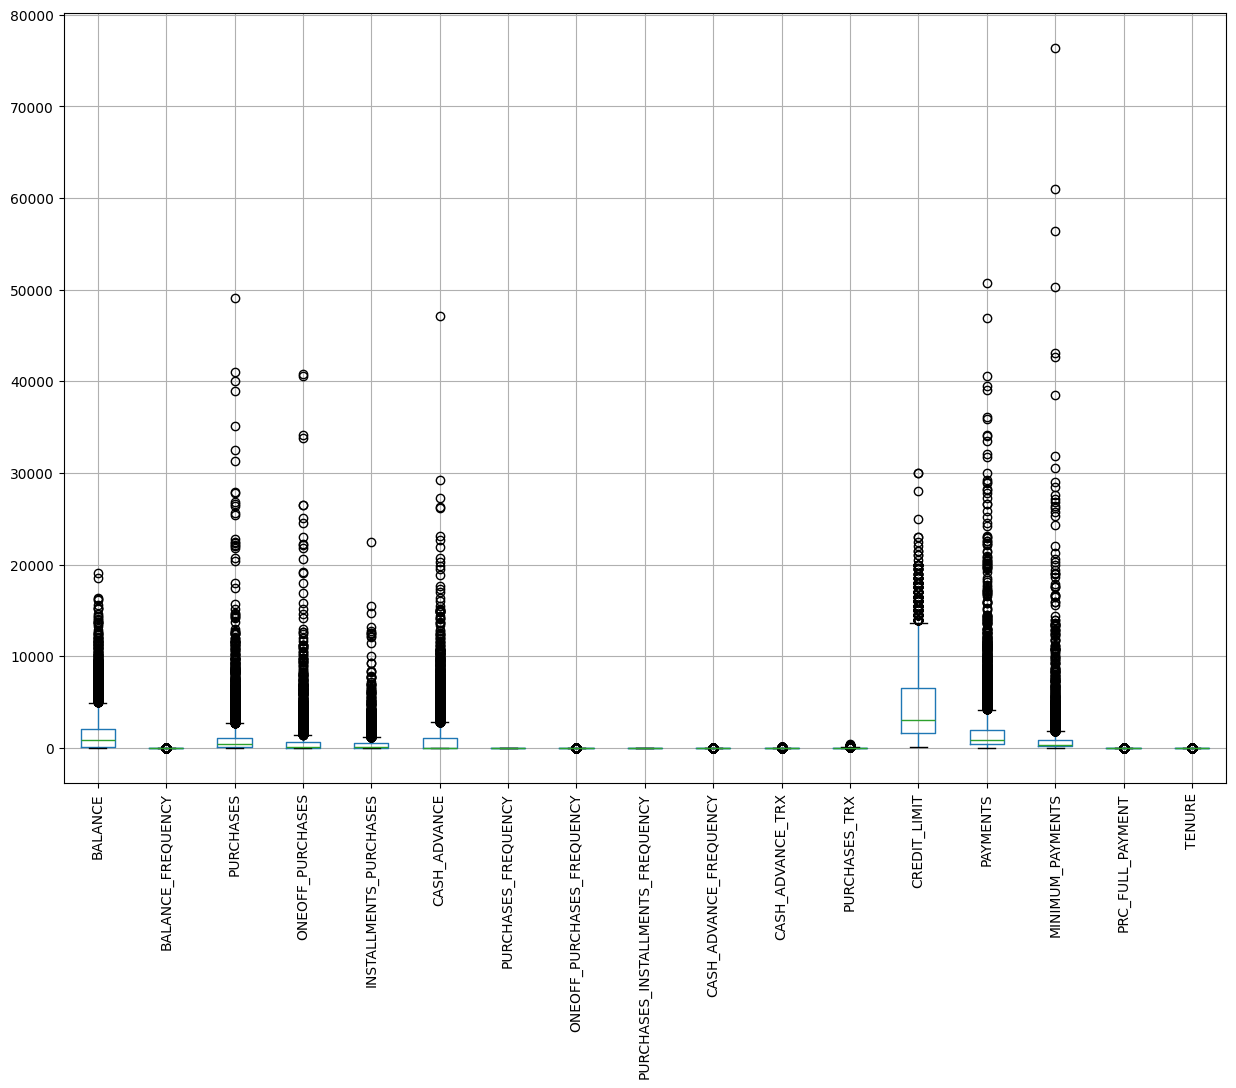

In [10]:
# Check for outliers using box plots
plt.figure(figsize=(15,10))
df.boxplot()
plt.xticks(rotation=90)
plt.show()

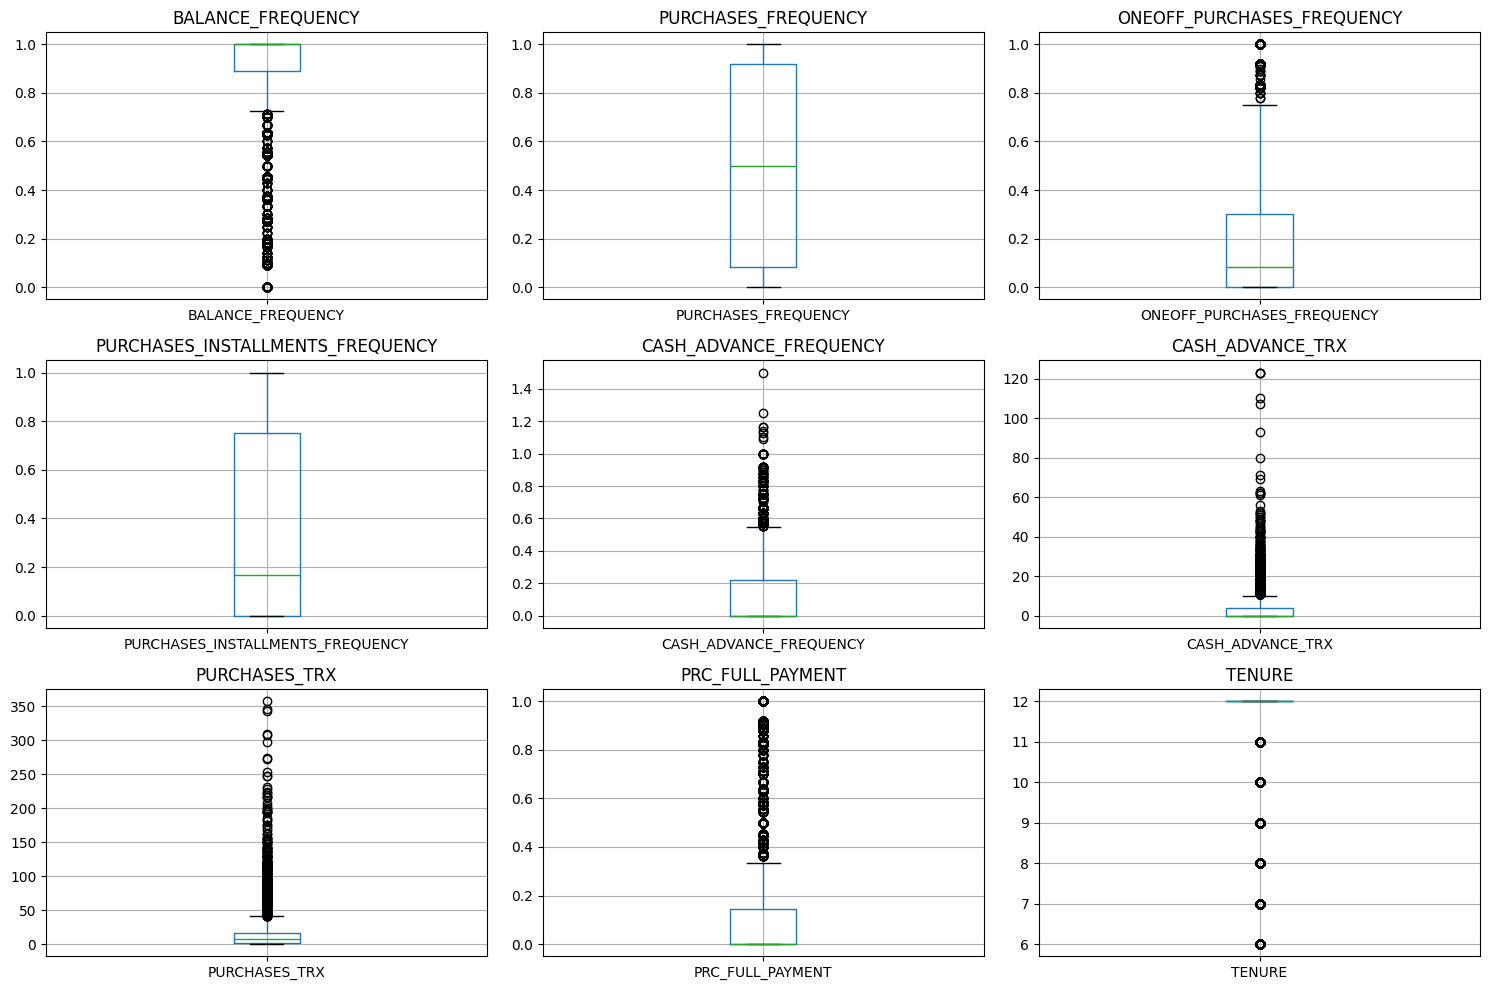

In [11]:
plt.figure(figsize=(15, 10))

columns_to_plot = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
                   'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 
                   'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'PRC_FULL_PAYMENT', 'TENURE']

for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 3, i)
    df.boxplot(column=[column])
    plt.title(column)

plt.tight_layout()
plt.show()


4- their is no duplicates in dataset

In [12]:
# Check for duplicate rows
df[df.duplicated()]

Empty DataFrame
Columns: [CUST_ID, BALANCE, BALANCE_FREQUENCY, PURCHASES, ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES, CASH_ADVANCE, PURCHASES_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, CASH_ADVANCE_FREQUENCY, CASH_ADVANCE_TRX, PURCHASES_TRX, CREDIT_LIMIT, PAYMENTS, MINIMUM_PAYMENTS, PRC_FULL_PAYMENT, TENURE]
Index: []

most of columns are skewed

41% of customers have balance from 0 to 500 

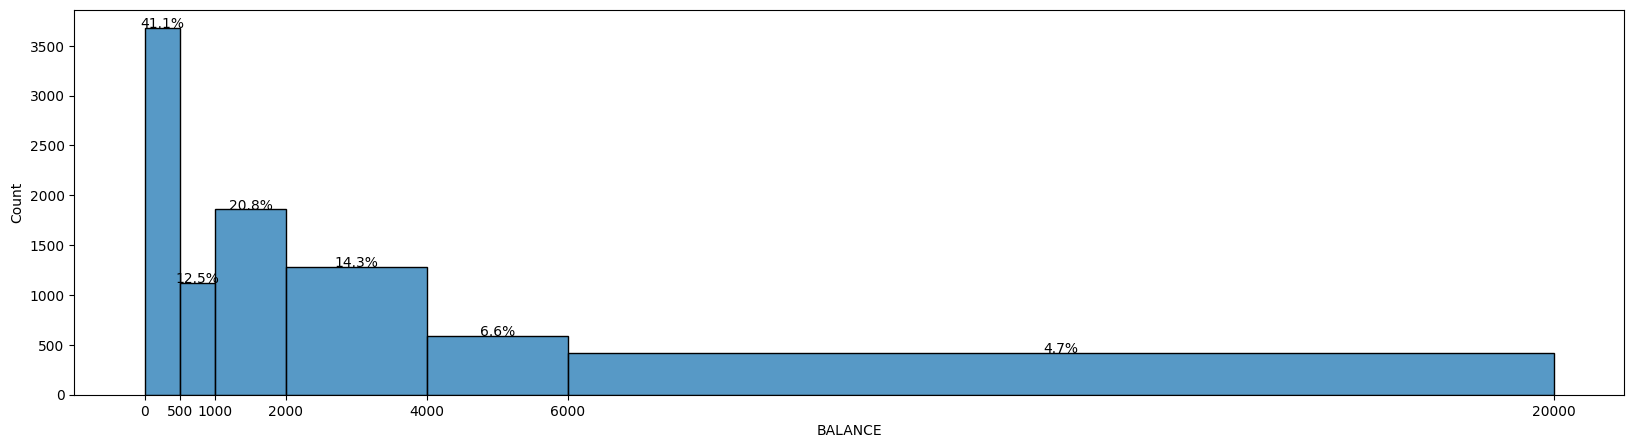

In [13]:
col = ['BALANCE']
bins = [0, 500, 1000, 2000,4000, 6000, 20000]
stat = ['count', 'percent']

for i in range(len(col)):
    plt.figure(figsize=(20, 5))
    ax = sns.histplot(data=df, x=col[i], bins=bins, stat=stat[i])

    total_count = len(df)

    patches = ax.patches
    for j in range(len(patches)):
        percentage = '{:.1f}%'.format(100 * (patches[j].get_height() / total_count))
        x = patches[j].get_x() + patches[j].get_width() / 2
        y = patches[j].get_height() + 0.05
        ax.annotate(percentage, (x, y), ha='center')
    ax.set_xticks(bins)

    plt.show()

more than 50% of customers have max total purchases 500

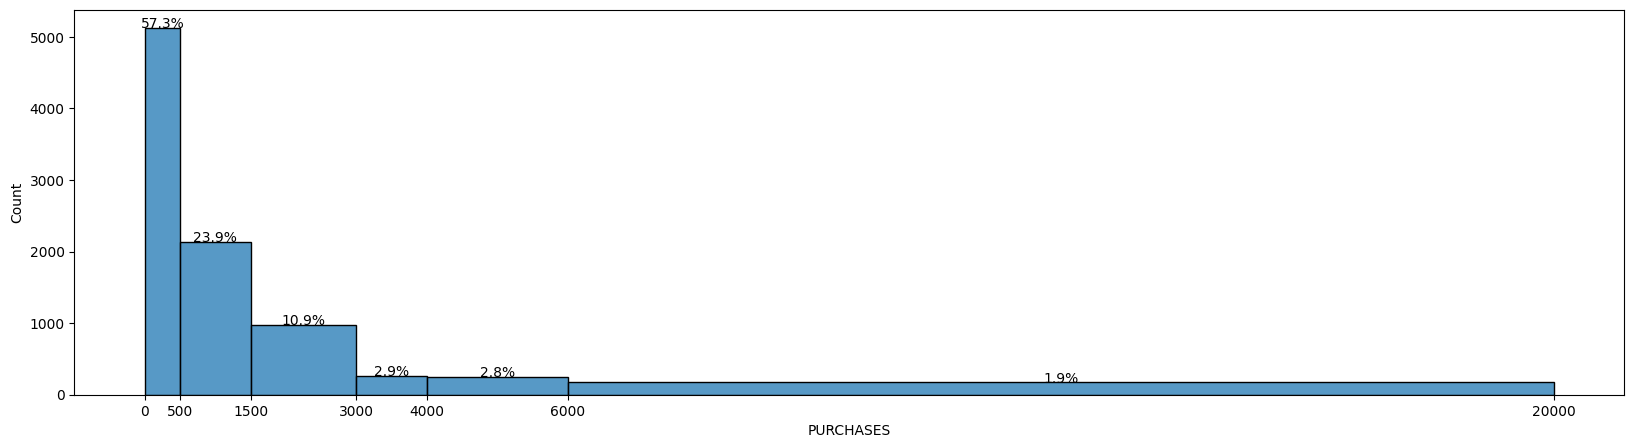

In [14]:
col = ['PURCHASES']
bins = [0, 500, 1500, 3000,4000, 6000, 20000]
stat = ['count', 'percent']

for i in range(len(col)):
    plt.figure(figsize=(20, 5))
    ax = sns.histplot(data=df, x=col[i], bins=bins, stat=stat[i])

    total_count = len(df)

    patches = ax.patches
    for j in range(len(patches)):
        percentage = '{:.1f}%'.format(100 * (patches[j].get_height() / total_count))
        x = patches[j].get_x() + patches[j].get_width() / 2
        y = patches[j].get_height() + 0.05
        ax.annotate(percentage, (x, y), ha='center')
    ax.set_xticks(bins)

    plt.show()


more than 80% of customers balanced frequency

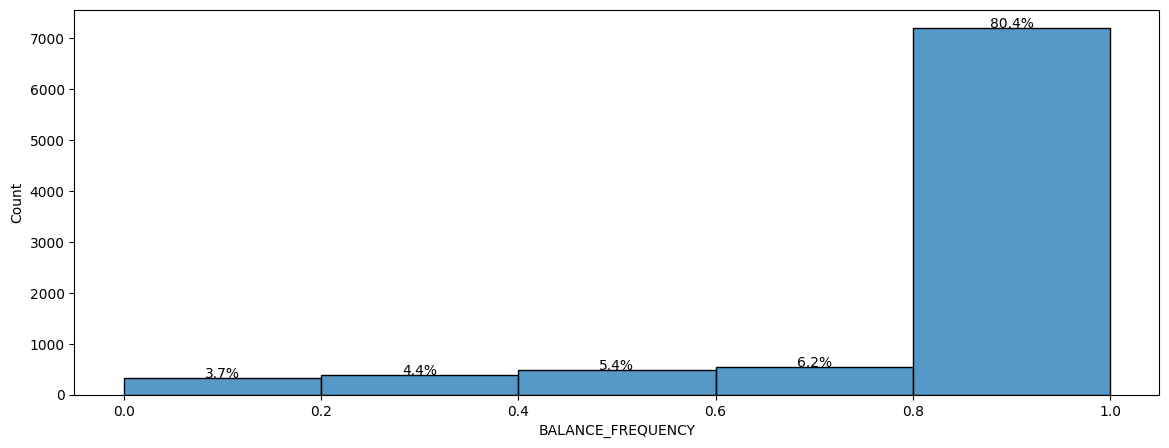

In [15]:
col=['BALANCE_FREQUENCY']
bins= [0,0.2,0.4,0.6,0.8,1]
stat=[ 'count','percent']

for i in range(len(col)):
    plt.figure(figsize=(14,5))
    ax= sns.histplot(data=df,x=col[i],bins=bins,stat=stat[i])
    total_count=len(df)
    patches = ax.patches
    for j in range(len(patches)):
        percentage= '{:,.1f}%'.format(100*(patches[j].get_height()/total_count))
        x= patches[j].get_x()+ patches[j].get_width()/2
        y= patches[j].get_height()+0.05
        ax.annotate(percentage,(x,y),ha = 'center')
    ax.set_xticks(bins)
    plt.show()

## 3. <a name="3">Data preprocessing</a>
(<a href="#0">Go to top</a>)


### Define below all the issues that you had found in the previous part
1- Null Vlaues <br>
2- Outliers <br>
3- skewed   <br>
4- id col <br>

In [16]:
#make a copy for the original dataset
df_copy=df.copy()

### for each issue adapt this methodology 
- start by defining the solution
- apply this solution onn the data
- test the solution to make sure that you have solved the issue

In [7]:
df.drop('CUST_ID', axis=1, inplace=True)

1 **First issue** nulls, we will check if there is a business meaning for these nulls or not 

In [8]:

null_minimum_payments = df[((df['MINIMUM_PAYMENTS'].isnull()) & (df['BALANCE'] == 0)) | ((df['MINIMUM_PAYMENTS'].isnull())& (df['PURCHASES'] == 0))]
null_minimum_payments

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
47    3910.111237           1.000000        0.0               0.0   
97    3505.671311           1.000000        0.0               0.0   
99       0.000000           0.000000        0.0               0.0   
111   3393.351236           1.000000        0.0               0.0   
129     69.405545           0.090909        0.0               0.0   
...           ...                ...        ...               ...   
8583  1029.111236           0.909091        0.0               0.0   
8647     0.006651           0.142857        0.0               0.0   
8719   165.240633           0.181818        0.0               0.0   
8755     3.036243           0.090909        0.0               0.0   
8929   371.527312           0.333333        0.0               0.0   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
47                       0.0   1980.873201                  0.0   
97                       0.0   1713.984305                  0.0   
99                       0.0     89.849004                  0.0   
111                      0.0   1008.348672                  0.0   
129                      0.0   2799.714934                  0.0   
...                      ...           ...                  ...   
8583                     0.0   1097.380897                  0.0   
8647                     0.0    164.137866                  0.0   
8719                     0.0   1088.751325                  0.0   
8755                     0.0     81.569379                  0.0   
8929                     0.0   1465.407927                  0.0   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
47                           0.0                               0.0   
97                           0.0                               0.0   
99                           0.0                               0.0   
111                          0.0                               0.0   
129                          0.0                               0.0   
...                          ...                               ...   
8583                         0.0                               0.0   
8647                         0.0                               0.0   
8719                         0.0                               0.0   
8755                         0.0                               0.0   
8929                         0.0                               0.0   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
47                  0.500000                 7              0        4200.0   
97                  0.500000                 6              0        4000.0   
99                  0.142857                 1              0        3000.0   
111                 0.083333                 2              0        4200.0   
129                 0.083333                 3              0       13000.0   
...                      ...               ...            ...           ...   
8583                0.166667                 4              0        1200.0   
8647                0.142857                 1              0        1200.0   
8719                0.166667                 4              0        1500.0   
8755                0.083333                 1              0         500.0   
8929                0.166667                 5              0        1500.0   

        PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
47      0.000000               NaN               0.0      12  
97      0.000000               NaN               0.0      12  
99    138.021428               NaN               0.0       7  
111     0.000000               NaN               0.0      12  
129     0.000000               NaN               0.0      12  
...          ...               ...               ...     ...  
8583    0.000000               NaN               0.0      12  
8647    5.070726               NaN               0.0       7  
8719    0.000000   

there are 313 null value which just 142 observation may have a relation between MINIMUM_PAYMENTS and BALANCE or MINIMUM_PAYMENTS and PURCHASES <br>
as there is no relation we can drop null values  

In [9]:
#solution 
df.dropna(inplace=True)

In [10]:
#test 
df.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

**Second and third issue** outliers is half of the data so we can't drop it , we can handle it using transformation

In [11]:
quantiles = df.quantile([0.25, 0.75])
iqr = quantiles.loc[0.75] - quantiles.loc[0.25]

outlier_threshold = 1.5 * iqr
outliers_count = ((df < quantiles.loc[0.25] - outlier_threshold) | (df > quantiles.loc[0.75] + outlier_threshold)).sum()

print(outliers_count)


BALANCE                              666
BALANCE_FREQUENCY                   1511
PURCHASES                            768
ONEOFF_PURCHASES                     961
INSTALLMENTS_PURCHASES               811
CASH_ADVANCE                         977
PURCHASES_FREQUENCY                    0
ONEOFF_PURCHASES_FREQUENCY           749
PURCHASES_INSTALLMENTS_FREQUENCY       0
CASH_ADVANCE_FREQUENCY               341
CASH_ADVANCE_TRX                     794
PURCHASES_TRX                        716
CREDIT_LIMIT                         243
PAYMENTS                             785
MINIMUM_PAYMENTS                     841
PRC_FULL_PAYMENT                    1343
TENURE                              1290
dtype: int64


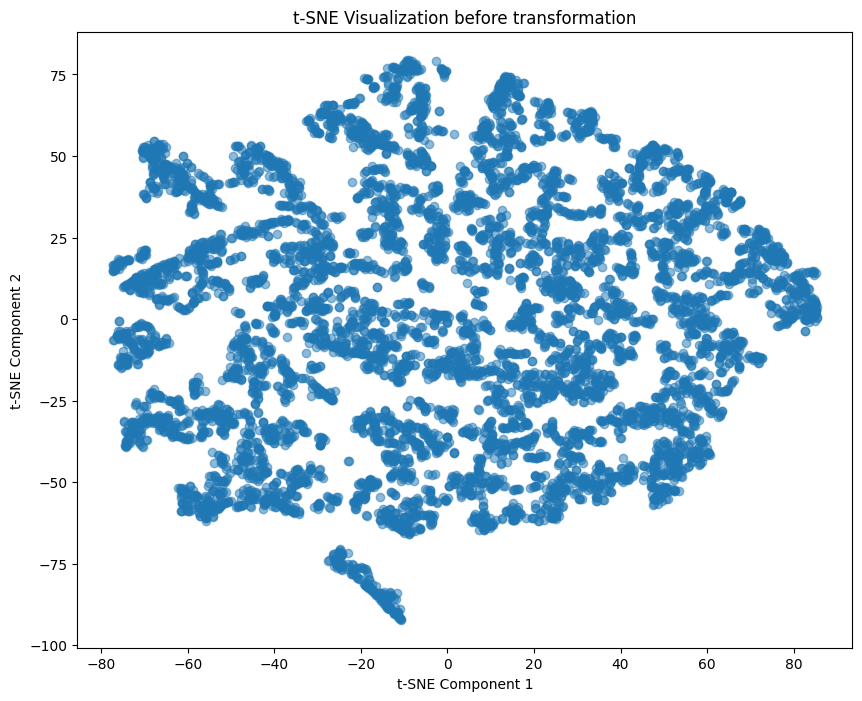

In [13]:
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(df)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.5)
plt.title('t-SNE Visualization before transformation')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


apply log transformation on data to handle outliers and skewness

In [14]:
df.skew() 

BALANCE                              2.374254
BALANCE_FREQUENCY                   -2.084161
PURCHASES                            8.055789
ONEOFF_PURCHASES                     9.935776
INSTALLMENTS_PURCHASES               7.216133
CASH_ADVANCE                         5.139629
PURCHASES_FREQUENCY                  0.033041
ONEOFF_PURCHASES_FREQUENCY           1.504234
PURCHASES_INSTALLMENTS_FREQUENCY     0.487753
CASH_ADVANCE_FREQUENCY               1.795915
CASH_ADVANCE_TRX                     5.673327
PURCHASES_TRX                        4.578418
CREDIT_LIMIT                         1.507019
PAYMENTS                             5.873049
MINIMUM_PAYMENTS                    13.622193
PRC_FULL_PAYMENT                     1.886027
TENURE                              -3.011141
dtype: float64

In [15]:
#solution 
                    
all_columns_except = ['BALANCE_FREQUENCY','ONEOFF_PURCHASES_FREQUENCY','CASH_ADVANCE_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_FREQUENCY',"PRC_FULL_PAYMENT" ]
columns_to_transform = [col for col in df.columns if col not in all_columns_except]

for column in columns_to_transform:
    df[column] = np.log(df[column] + 0.1)


In [16]:
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  3.713590           0.818182   4.559126         -2.302585   
1  8.071708           0.909091  -2.302585         -2.302585   
2  7.822144           1.000000   6.650628          6.650628   
4  6.706635           1.000000   2.778819          2.778819   
5  7.501043           1.000000   7.195472         -2.302585   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                4.559126     -2.302585             0.166667   
1               -2.302585      8.770757             0.000000   
2               -2.302585     -2.302585             1.000000   
4               -2.302585     -2.302585             0.083333   
5                7.195472     -2.302585             0.666667   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
4                    0.083333                          0.000000   
5                    0.000000                          0.583333   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                    0.00         -2.302585       0.741937      6.907855   
1                    0.25          1.410987      -2.302585      8.853680   
2                    0.00         -2.302585       2.493205      8.922672   
4                    0.00         -2.302585       0.095310      7.090160   
5                    0.00         -2.302585       2.091864      7.495597   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  
0  5.307783          4.938851          0.000000  2.493205  
1  8.319506          6.977692          0.222222  2.493205  
2  6.433208          6.441560          0.000000  2.493205  
4  6.519788          5.500814          0.000000  2.493205  
5  7.244340          7.786280          0.000000  2.493205

In [17]:
quantiles = df.quantile([0.25, 0.75])
iqr = quantiles.loc[0.75] - quantiles.loc[0.25]

outlier_threshold = 1.5 * iqr
outliers_count = ((df < quantiles.loc[0.25] - outlier_threshold) | (df > quantiles.loc[0.75] + outlier_threshold)).sum()

print(outliers_count)


BALANCE                               95
BALANCE_FREQUENCY                   1511
PURCHASES                           1971
ONEOFF_PURCHASES                       0
INSTALLMENTS_PURCHASES                 0
CASH_ADVANCE                           0
PURCHASES_FREQUENCY                    0
ONEOFF_PURCHASES_FREQUENCY           749
PURCHASES_INSTALLMENTS_FREQUENCY       0
CASH_ADVANCE_FREQUENCY               341
CASH_ADVANCE_TRX                       0
PURCHASES_TRX                          0
CREDIT_LIMIT                           6
PAYMENTS                              98
MINIMUM_PAYMENTS                     145
PRC_FULL_PAYMENT                    1343
TENURE                              1290
dtype: int64


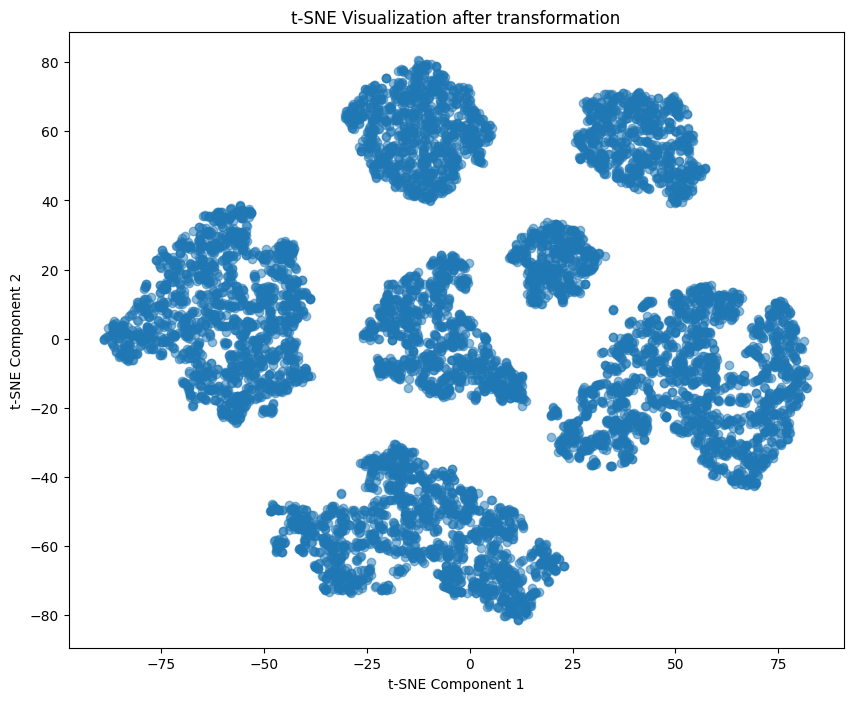

In [18]:

tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(df)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], alpha=0.5)
plt.title('t-SNE Visualization after transformation')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


## 4. <a name="4">Features transformation</a>
(<a href="#0">Go to top</a>)

*What is the feature scaling technique that would use and why?* <br>
*return to this section again and try another technique and see how that will impact your result*<br>
for more details on different methods for scaling check these links
- https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
- https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
- https://www.analyticsvidhya.com/blog/2020/07/types-of-feature-transformation-and-scaling/

Answer here: MinMaxScaler is a suitable choice for feature scaling in this scenario because it scales the data to a fixed range, typically [0, 1]. as it relies on distances between data points in the high-dimensional space. By scaling the features to a common range, MinMaxScaler ensures that all features contribute equally to the distance computations, resulting in a more meaningful and accurate representation of the data in the t-SNE visualization.

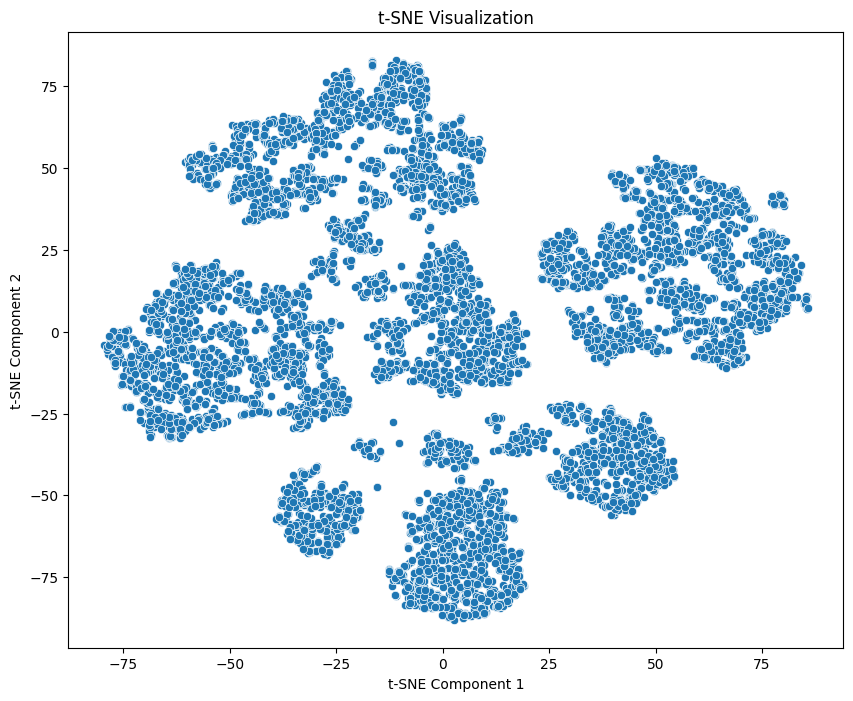

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(scaled_data)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


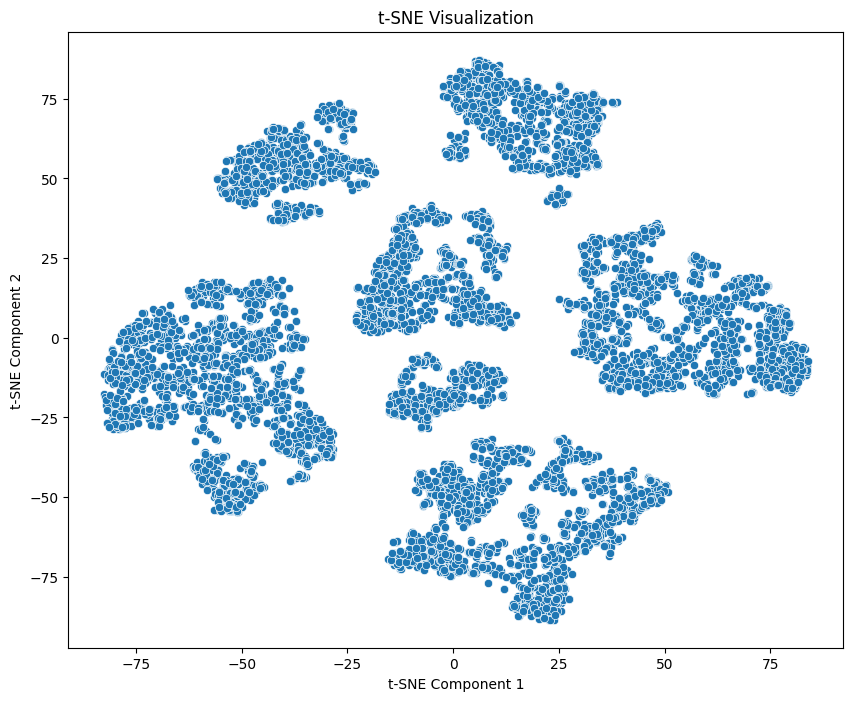

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Perform t-SNE

tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(scaled_data)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


In [34]:
min_max_df = pd.DataFrame(scaled_data, columns=df.columns)
min_max_df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  0.494871           0.818182   0.523676          0.000000   
1  0.853356           0.909091   0.000000          0.000000   
2  0.832828           1.000000   0.683296          0.693076   
3  0.741069           1.000000   0.387806          0.393356   
4  0.806415           1.000000   0.724878          0.000000   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                0.556783      0.000000             0.166667   
1                0.000000      0.847661             0.000000   
2                0.000000      0.000000             1.000000   
3                0.000000      0.000000             0.083333   
4                0.770705      0.000000             0.666667   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.000000                          0.583333   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000          0.000000       0.372036      0.468157   
1                0.166667          0.521893       0.000000      0.772433   
2                0.000000          0.000000       0.586039      0.783222   
3                0.000000          0.000000       0.293020      0.496665   
4                0.000000          0.000000       0.536996      0.560065   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
0  0.566035          0.528462          0.000000     1.0  
1  0.802536          0.680944          0.222222     1.0  
2  0.654411          0.640847          0.000000     1.0  
3  0.661210          0.570491          0.000000     1.0  
4  0.718107          0.741417          0.000000     1.0

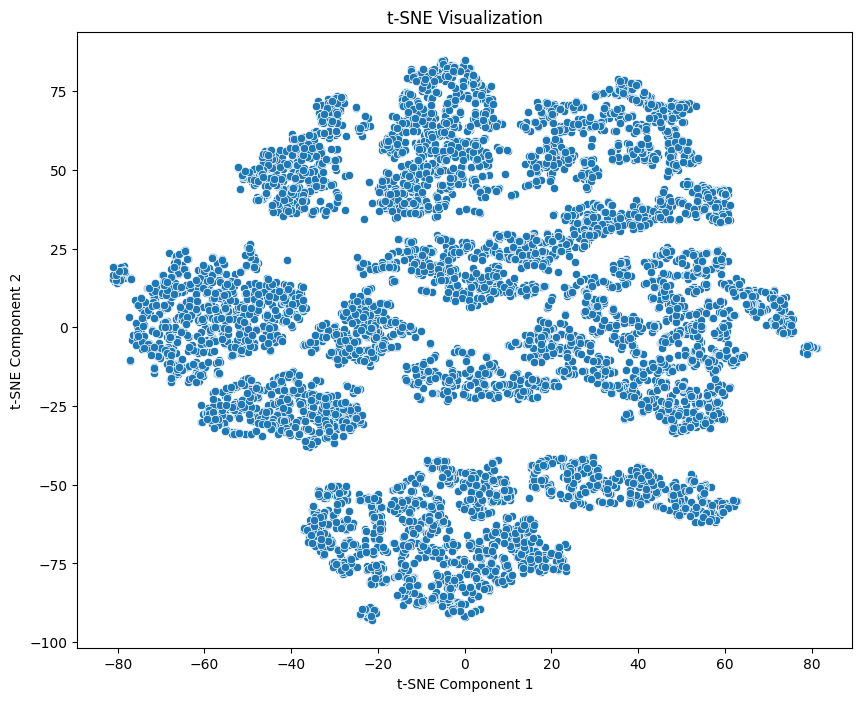

In [35]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
scaled_data = scaler.fit_transform(df)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(scaled_data)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


## 5. <a name="5">K Means</a>
(<a href="#5">Go to top</a>)

1- Use the k means class that you implemented in the previous task to cluster this data
2- Use http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html and see if the difference in the result
3- Use elbow method to determine the K (plot the result using two plot one for distorion and another for inertia)
4- (Optionally) make a method that pick the best number of clusters for you 
5- Using different techniques for scaling and comment on the result

In [19]:
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  3.713590           0.818182   4.559126         -2.302585   
1  8.071708           0.909091  -2.302585         -2.302585   
2  7.822144           1.000000   6.650628          6.650628   
4  6.706635           1.000000   2.778819          2.778819   
5  7.501043           1.000000   7.195472         -2.302585   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                4.559126     -2.302585             0.166667   
1               -2.302585      8.770757             0.000000   
2               -2.302585     -2.302585             1.000000   
4               -2.302585     -2.302585             0.083333   
5                7.195472     -2.302585             0.666667   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
4                    0.083333                          0.000000   
5                    0.000000                          0.583333   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                    0.00         -2.302585       0.741937      6.907855   
1                    0.25          1.410987      -2.302585      8.853680   
2                    0.00         -2.302585       2.493205      8.922672   
4                    0.00         -2.302585       0.095310      7.090160   
5                    0.00         -2.302585       2.091864      7.495597   

   PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT    TENURE  
0  5.307783          4.938851          0.000000  2.493205  
1  8.319506          6.977692          0.222222  2.493205  
2  6.433208          6.441560          0.000000  2.493205  
4  6.519788          5.500814          0.000000  2.493205  
5  7.244340          7.786280          0.000000  2.493205

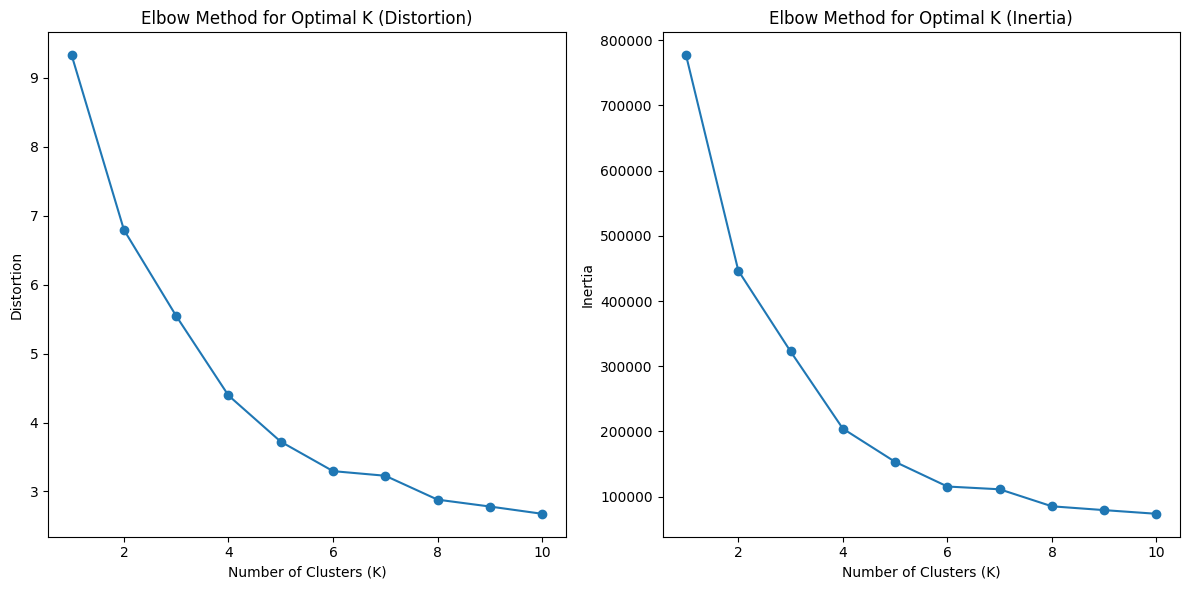

In [21]:

distortions = []
inertias = []

K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df)
    
    distortions.append(sum(np.min(cdist(df, kmeans.cluster_centers_,'euclidean'), axis=1)) / df.shape[0])
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12, 6))

# Plot distortion
plt.subplot(1, 2, 1)
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal K (Distortion)')

# Plot inertia
plt.subplot(1, 2, 2)
plt.plot(K_range, inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K (Inertia)')

plt.tight_layout()
plt.show()


choose number of k = 7

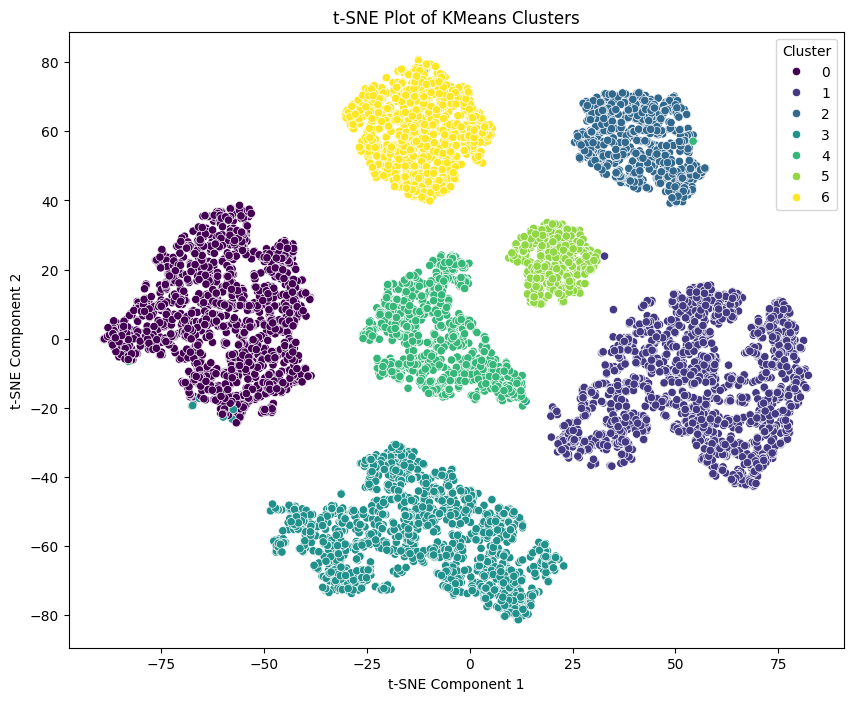

In [31]:

kmeans = KMeans(n_clusters=7)
kmeans_labels = kmeans.fit_predict(df)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(df)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1], hue=kmeans_labels, palette='viridis', legend='full')
plt.title('t-SNE Plot of KMeans Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

DBSCAN

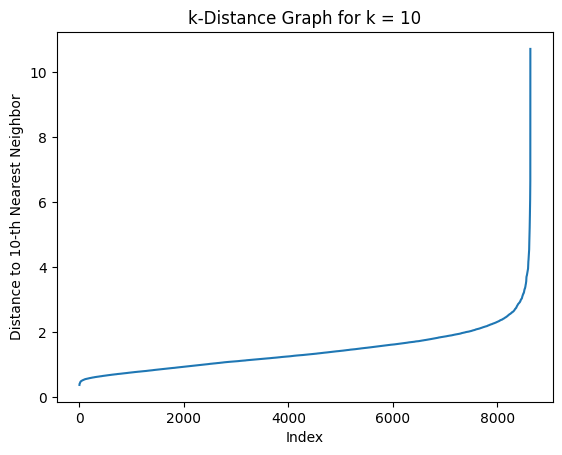

In [33]:
from sklearn.neighbors import NearestNeighbors

k = 10  
neighbors = NearestNeighbors(n_neighbors=k)
neighbors.fit(df)
distances, indices = neighbors.kneighbors(df)

sorted_distances = np.sort(distances[:, -1])

plt.plot(np.arange(len(df)), sorted_distances)
plt.xlabel('Index')
plt.ylabel(f'Distance to {k}-th Nearest Neighbor')
plt.title(f'k-Distance Graph for k = {k}')
plt.show()


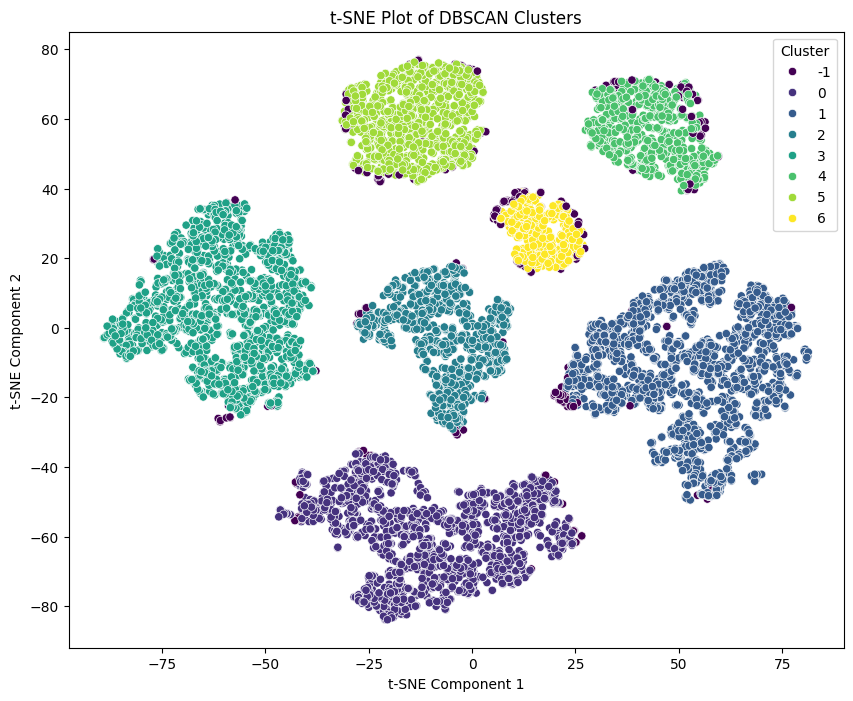

In [34]:
from sklearn.cluster import DBSCAN

# Choose an eps value within the range of 2 to 4
eps = 3

dbscan = DBSCAN(eps=eps, min_samples=150) 
dbscan.fit(df)

cluster_labels = dbscan.labels_

# Visualize the clusters using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(df)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1], hue=cluster_labels, palette='viridis', legend='full')
plt.title('t-SNE Plot of DBSCAN Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


## 6. <a name="5">Training and hyperparamter tuning</a>
(<a href="#0">Go to top</a>)


Before we start the training process we need to specify 3 paramters:<br>
1- Linkage criteria : The linkage criterion determines the distance between two clusters
    - Complete-Linkage Clustering
    - Single-Linkage Clustering
    - Average-Linkage Clustering
    - Centroid Linkage Clustering
2- Distance function:
    - Euclidean Distance 
    - Manhattan Distance 
    - Mahalanobis distance 
3- Number of clusters


### *Number of clusters*
Use Dendograms to specify the optimum number of clusters
- Compare how changing linkage criteria or distance function would affect the optimum number of clusters
- you can use silhouette_score or any other evalution method to help you determine the optimum number of clusters
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

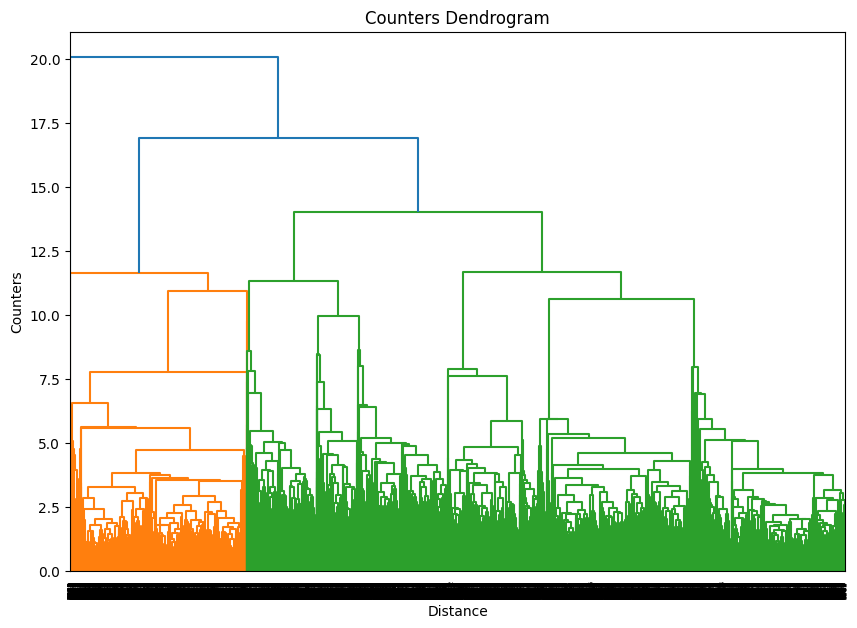

In [35]:
import scipy.cluster.hierarchy as shc

linkage_criteria = 'average'  
distance_function = 'euclidean'  

linkage_matrix = shc.linkage(df, method=linkage_criteria, metric=distance_function)

plt.figure(figsize=(10, 7))
plt.title("Counters Dendrogram")
dend = shc.dendrogram(linkage_matrix)

plt.xlabel('Distance')
plt.ylabel('Counters')
plt.show()


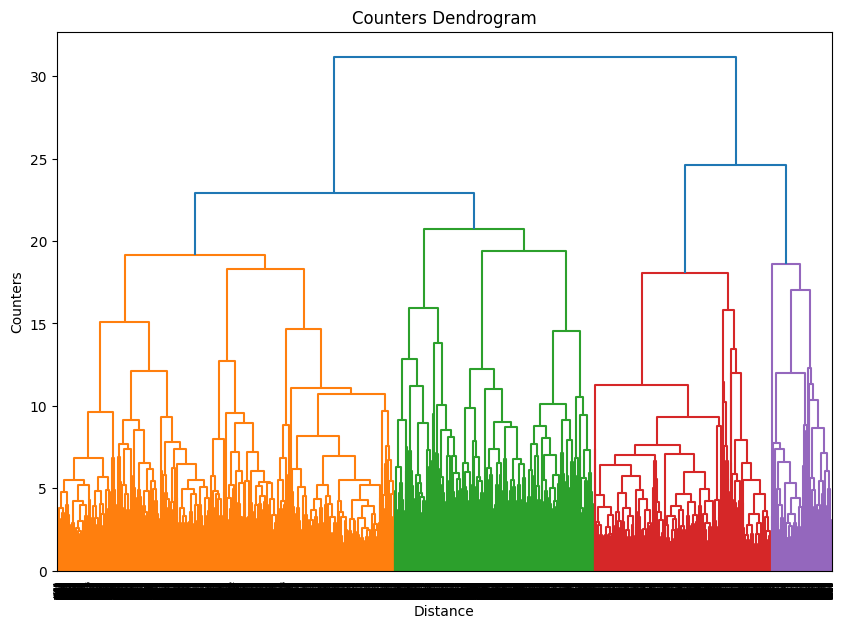

In [36]:
linkage_criteria = 'complete'  
distance_function = 'euclidean'  

linkage_matrix = shc.linkage(df, method=linkage_criteria, metric=distance_function)

plt.figure(figsize=(10, 7))
plt.title("Counters Dendrogram")
dend = shc.dendrogram(linkage_matrix)

plt.xlabel('Distance')
plt.ylabel('Counters')
plt.show()


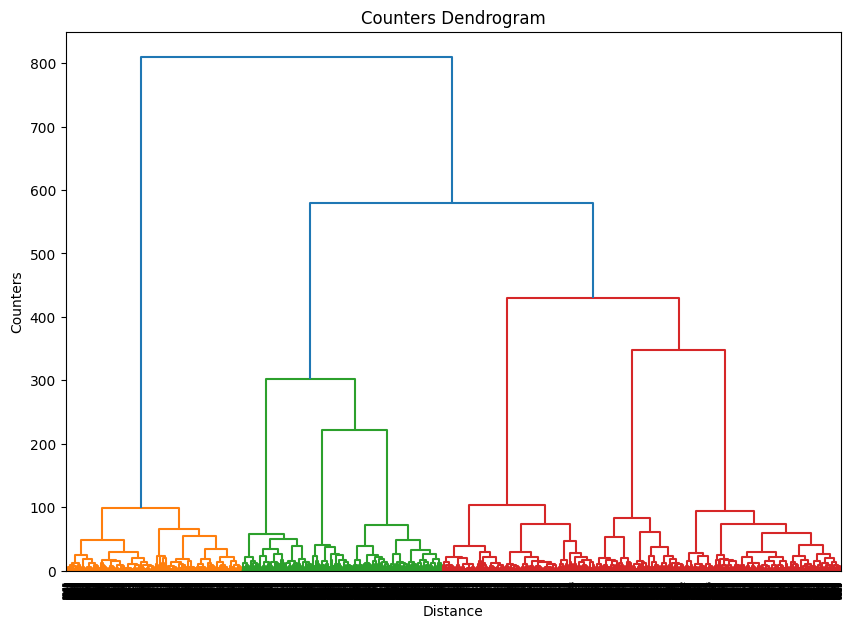

In [37]:
linkage_criteria = 'ward'  
distance_function = 'euclidean'  

linkage_matrix = shc.linkage(df, method=linkage_criteria, metric=distance_function)

plt.figure(figsize=(10, 7))
plt.title("Counters Dendrogram")
dend = shc.dendrogram(linkage_matrix)

plt.xlabel('Distance')
plt.ylabel('Counters')
plt.show()


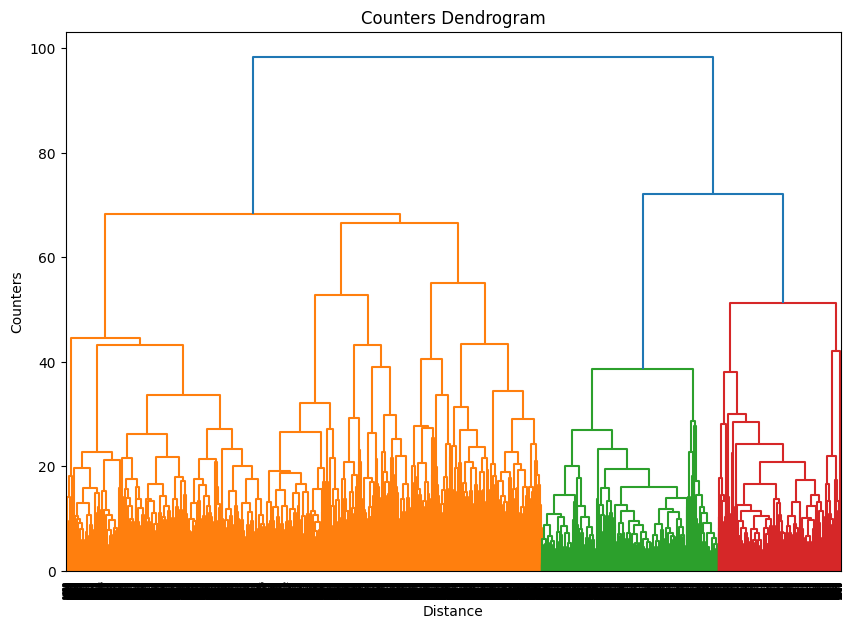

In [38]:
linkage_criteria = 'complete'  
distance_function = 'cityblock'  

linkage_matrix = shc.linkage(df, method=linkage_criteria, metric=distance_function)

plt.figure(figsize=(10, 7))
plt.title("Counters Dendrogram")
dend = shc.dendrogram(linkage_matrix)

plt.xlabel('Distance')
plt.ylabel('Counters')
plt.show()

silhouette score has high value on clusters 7 as it near 1 so we choose 7 clusters

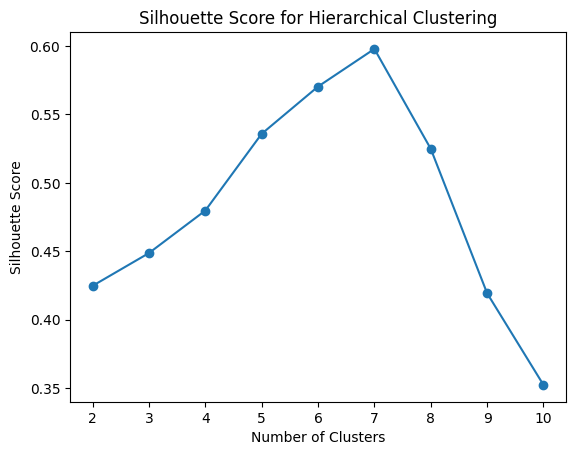

In [39]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering

silhouette_scores = []
num_clusters_range = range(2, 11)  

for num_clusters in num_clusters_range:

    clustering = AgglomerativeClustering(n_clusters=num_clusters)
    cluster_labels = clustering.fit_predict(df)
   
    silhouette_avg = silhouette_score(df, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(num_clusters_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Hierarchical Clustering')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


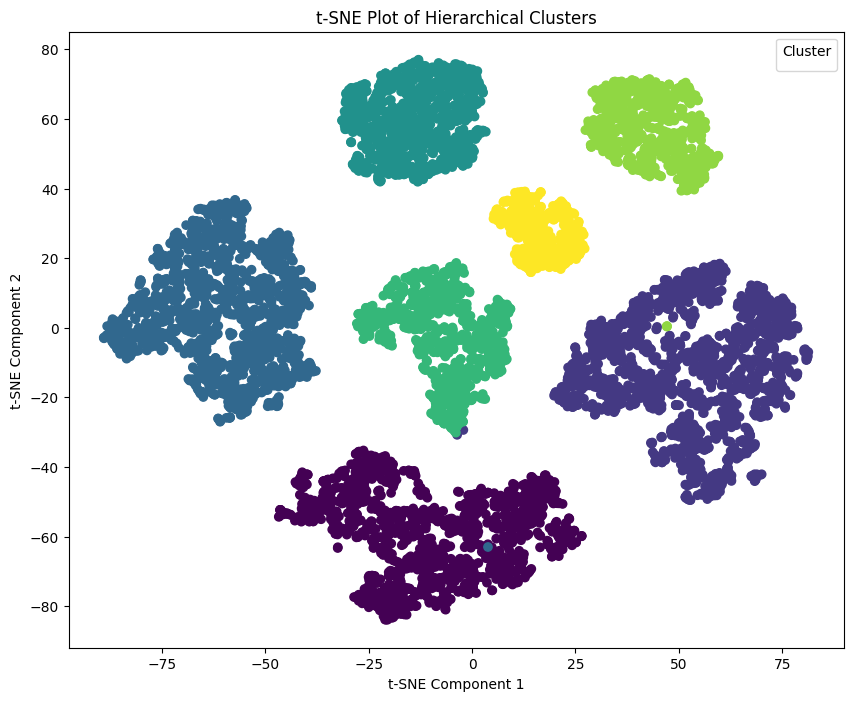

In [41]:
#training

# by defualt it use "ward", "euclidean"
num_clusters = 7
agglomerative_clustering = AgglomerativeClustering(n_clusters=num_clusters)

agglomerative_clustering.fit(df)

Hierarchical_cluster_labels = agglomerative_clustering.labels_

tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(df)
plt.figure(figsize=(10, 8))
plt.scatter(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1], c=Hierarchical_cluster_labels)
plt.title('t-SNE Plot of Hierarchical Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


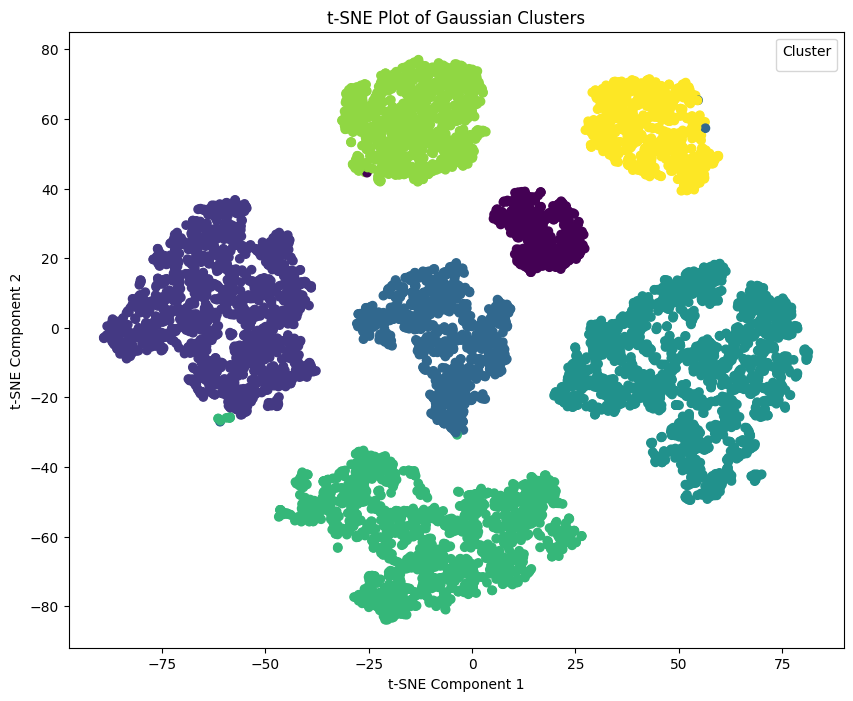

In [43]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=7)

gmm.fit(df)


Gaussian_cluster_labels = gmm.predict(df)

tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(df)
plt.figure(figsize=(10, 8))
plt.scatter(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1], c=Gaussian_cluster_labels)
plt.title('t-SNE Plot of Gaussian Clusters')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Cluster')
plt.show()

from visualization Hierarchical_cluster was the best clustring algorithim so we will split the data into 7 clusters based on it.


In [49]:
data_path = 'D:\\ITI\Machine Learning\\unsupervised\\notebook\\last project\\CC GENERAL.csv'  #the path where you downloaded the data
df = pd.read_csv(data_path)
df.drop('CUST_ID', axis=1, inplace=True)
df.dropna(inplace=True)

In [50]:
df['cluster']=Hierarchical_cluster_labels

In [51]:
df.head()

BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0    40.900749           0.818182      95.40              0.00   
1  3202.467416           0.909091       0.00              0.00   
2  2495.148862           1.000000     773.17            773.17   
4   817.714335           1.000000      16.00             16.00   
5  1809.828751           1.000000    1333.28              0.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                   95.40      0.000000             0.166667   
1                    0.00   6442.945483             0.000000   
2                    0.00      0.000000             1.000000   
4                    0.00      0.000000             0.083333   
5                 1333.28      0.000000             0.666667   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
4                    0.083333                          0.000000   
5                    0.000000                          0.583333   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                    0.00                 0              2        1000.0   
1                    0.25                 4              0        7000.0   
2                    0.00                 0             12        7500.0   
4                    0.00                 0              1        1200.0   
5                    0.00                 0              8        1800.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  cluster  
0   201.802084        139.509787          0.000000      12        0  
1  4103.032597       1072.340217          0.222222      12        1  
2   622.066742        627.284787          0.000000      12        4  
4   678.334763        244.791237          0.000000      12        4  
5  1400.057770       2407.246035          0.000000      12        0

cluster 0 --> Low Balance, Low Transaction,Cluster 0 represents customers who maintain low balances in their accounts and primarily engage in low-value purchase transactions. This segment may include customers who use their credit cards sparingly for essential purchases or those who prefer cash transactions for everyday expenses.

cluster 1--> smaller proportion of customers (around 31%) have balances between 1000 and 2000 and it is also consider low ,Their purchase behavior aligns with their low balances, primarily engaging in transactions between 0 and 500.

cluster 2 --> This cluster encompasses a heterogeneous mix of customers with varying financial profiles and spending habits. It may include individuals with different income levels, financial goals, and preferences.

cluster 3 --> Customers in this cluster exhibit a varied distribution of account balances, possibly resembling a normal distribution with notable concentrations around 0, 500, and 2000. Their transaction patterns for both installments purchases and regular purchases show moderate activity across different value ranges.

cluster 4 --> Customers in this cluster maintain relatively low balances, with a significant portion having balances between 0 and 200. Their purchase behavior primarily revolves around installment purchases, with all customers engaging exclusively in transactions within the 0-200 range. This cluster represents a segment of customers who prioritize installment purchases.

cluster 5 --> Customers in this cluster exhibit a balanced distribution of account balances, resembling a normal distribution with notable concentrations around 500 and 2000. However, a significant portion of customers also maintains low balances below 200. Despite the variation in balances, all customers in this cluster exclusively engage in installment purchases within the 0-200 range. Regular purchases also occur across different value ranges, with a notable concentration in the 0-200 range


cluster 6 --> This cluster represents a balanced mix of customers with diverse transaction behaviors. The normal distribution of account balances suggests a relatively even distribution of financial capacities among customers.

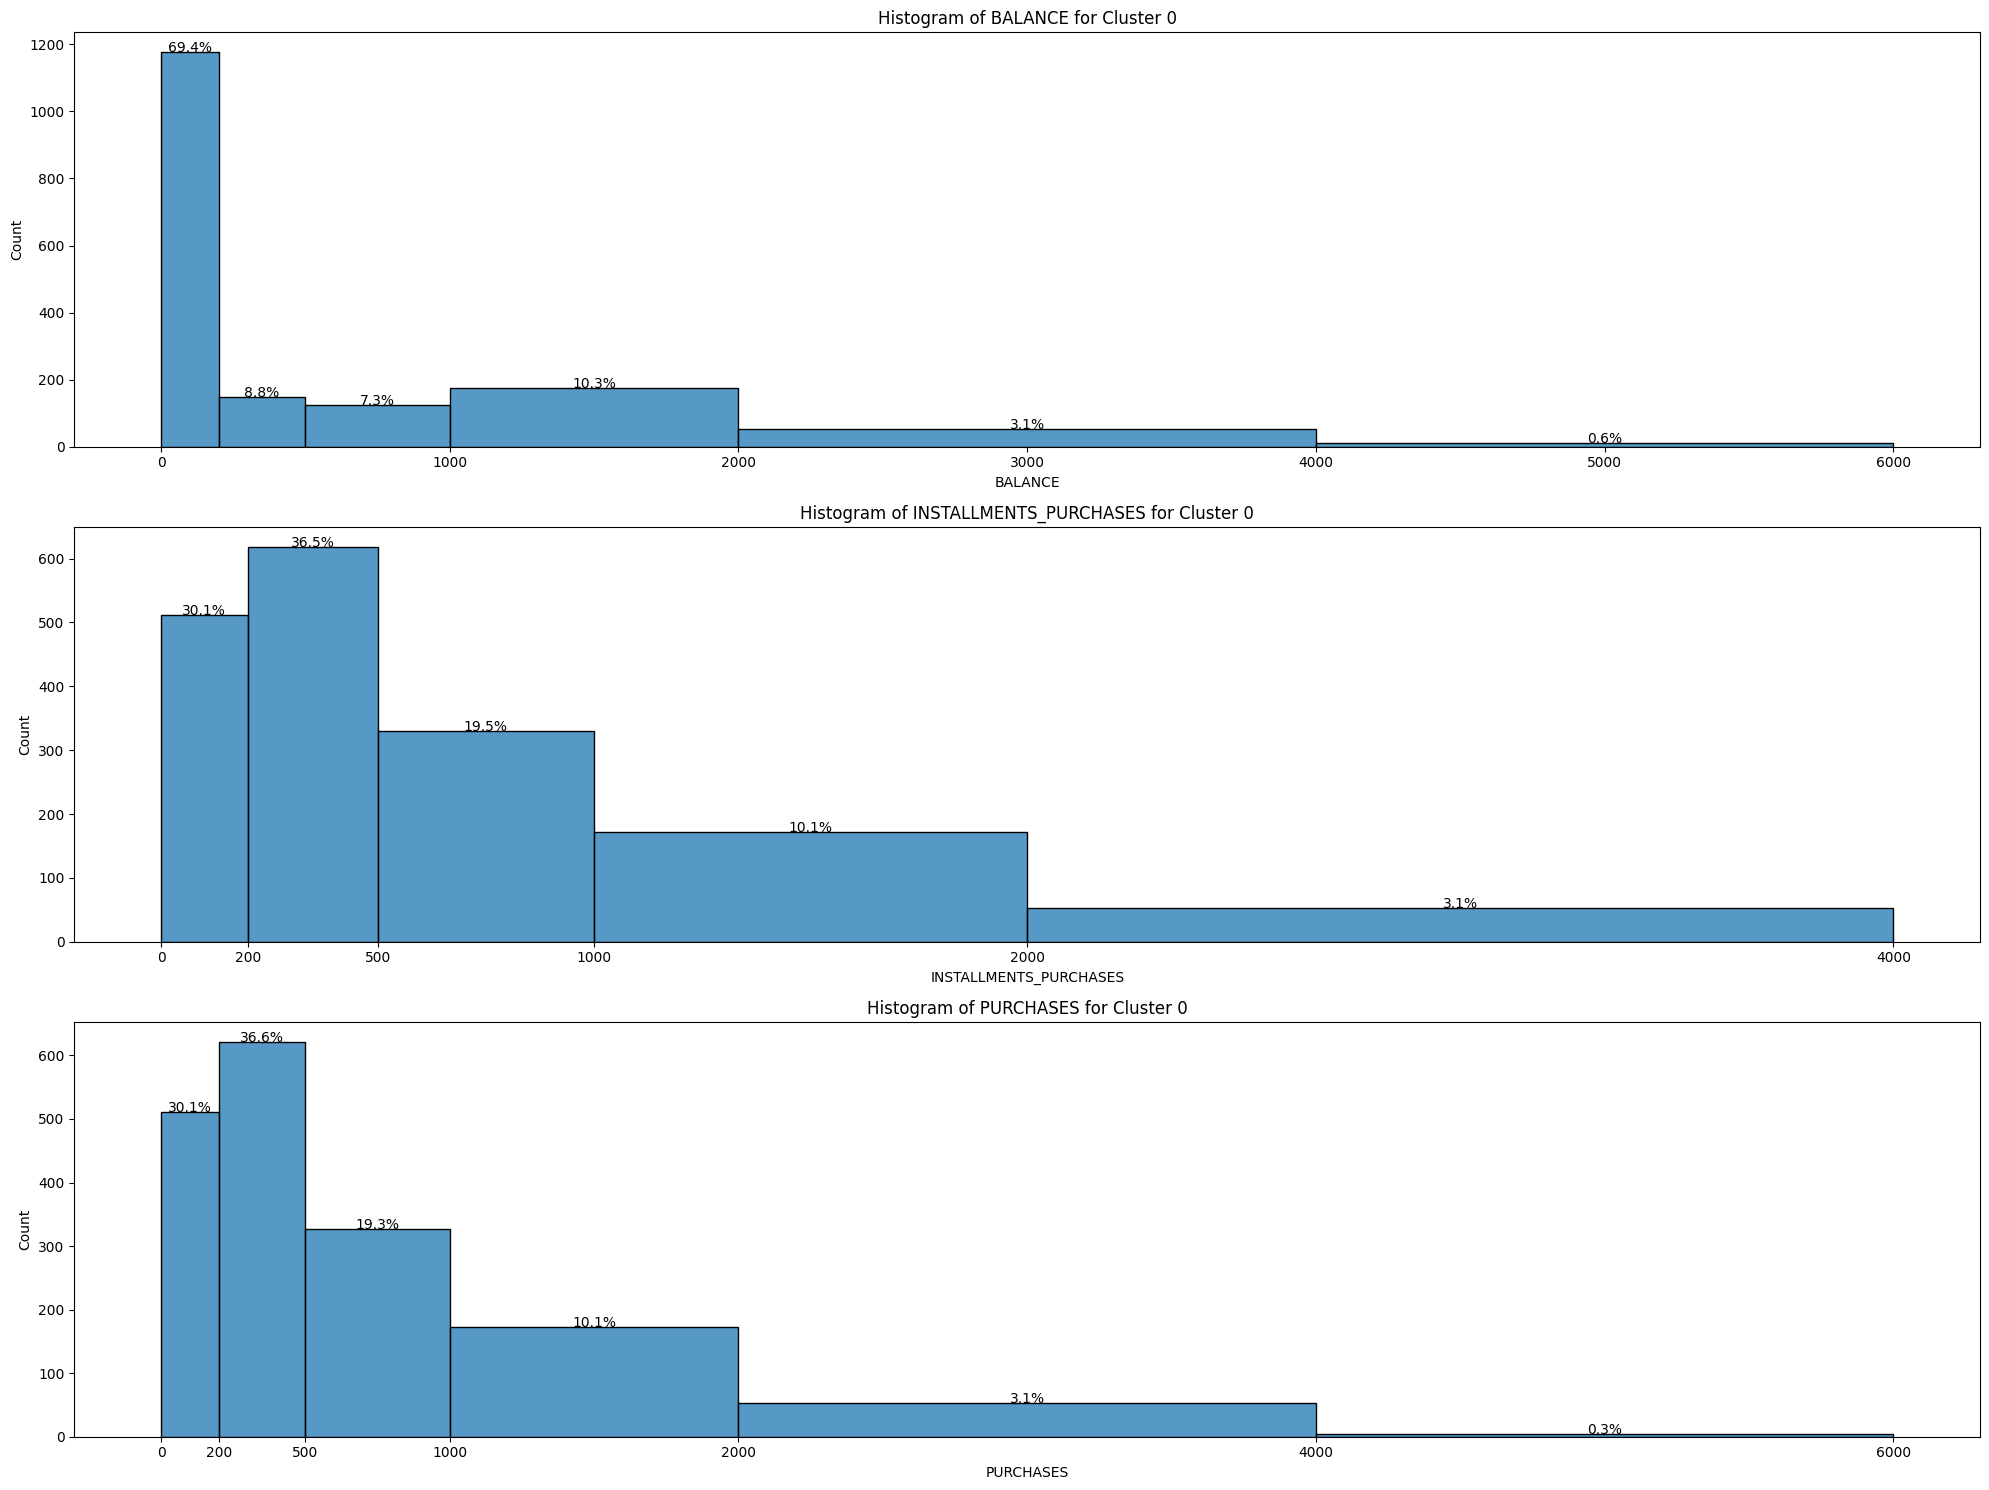

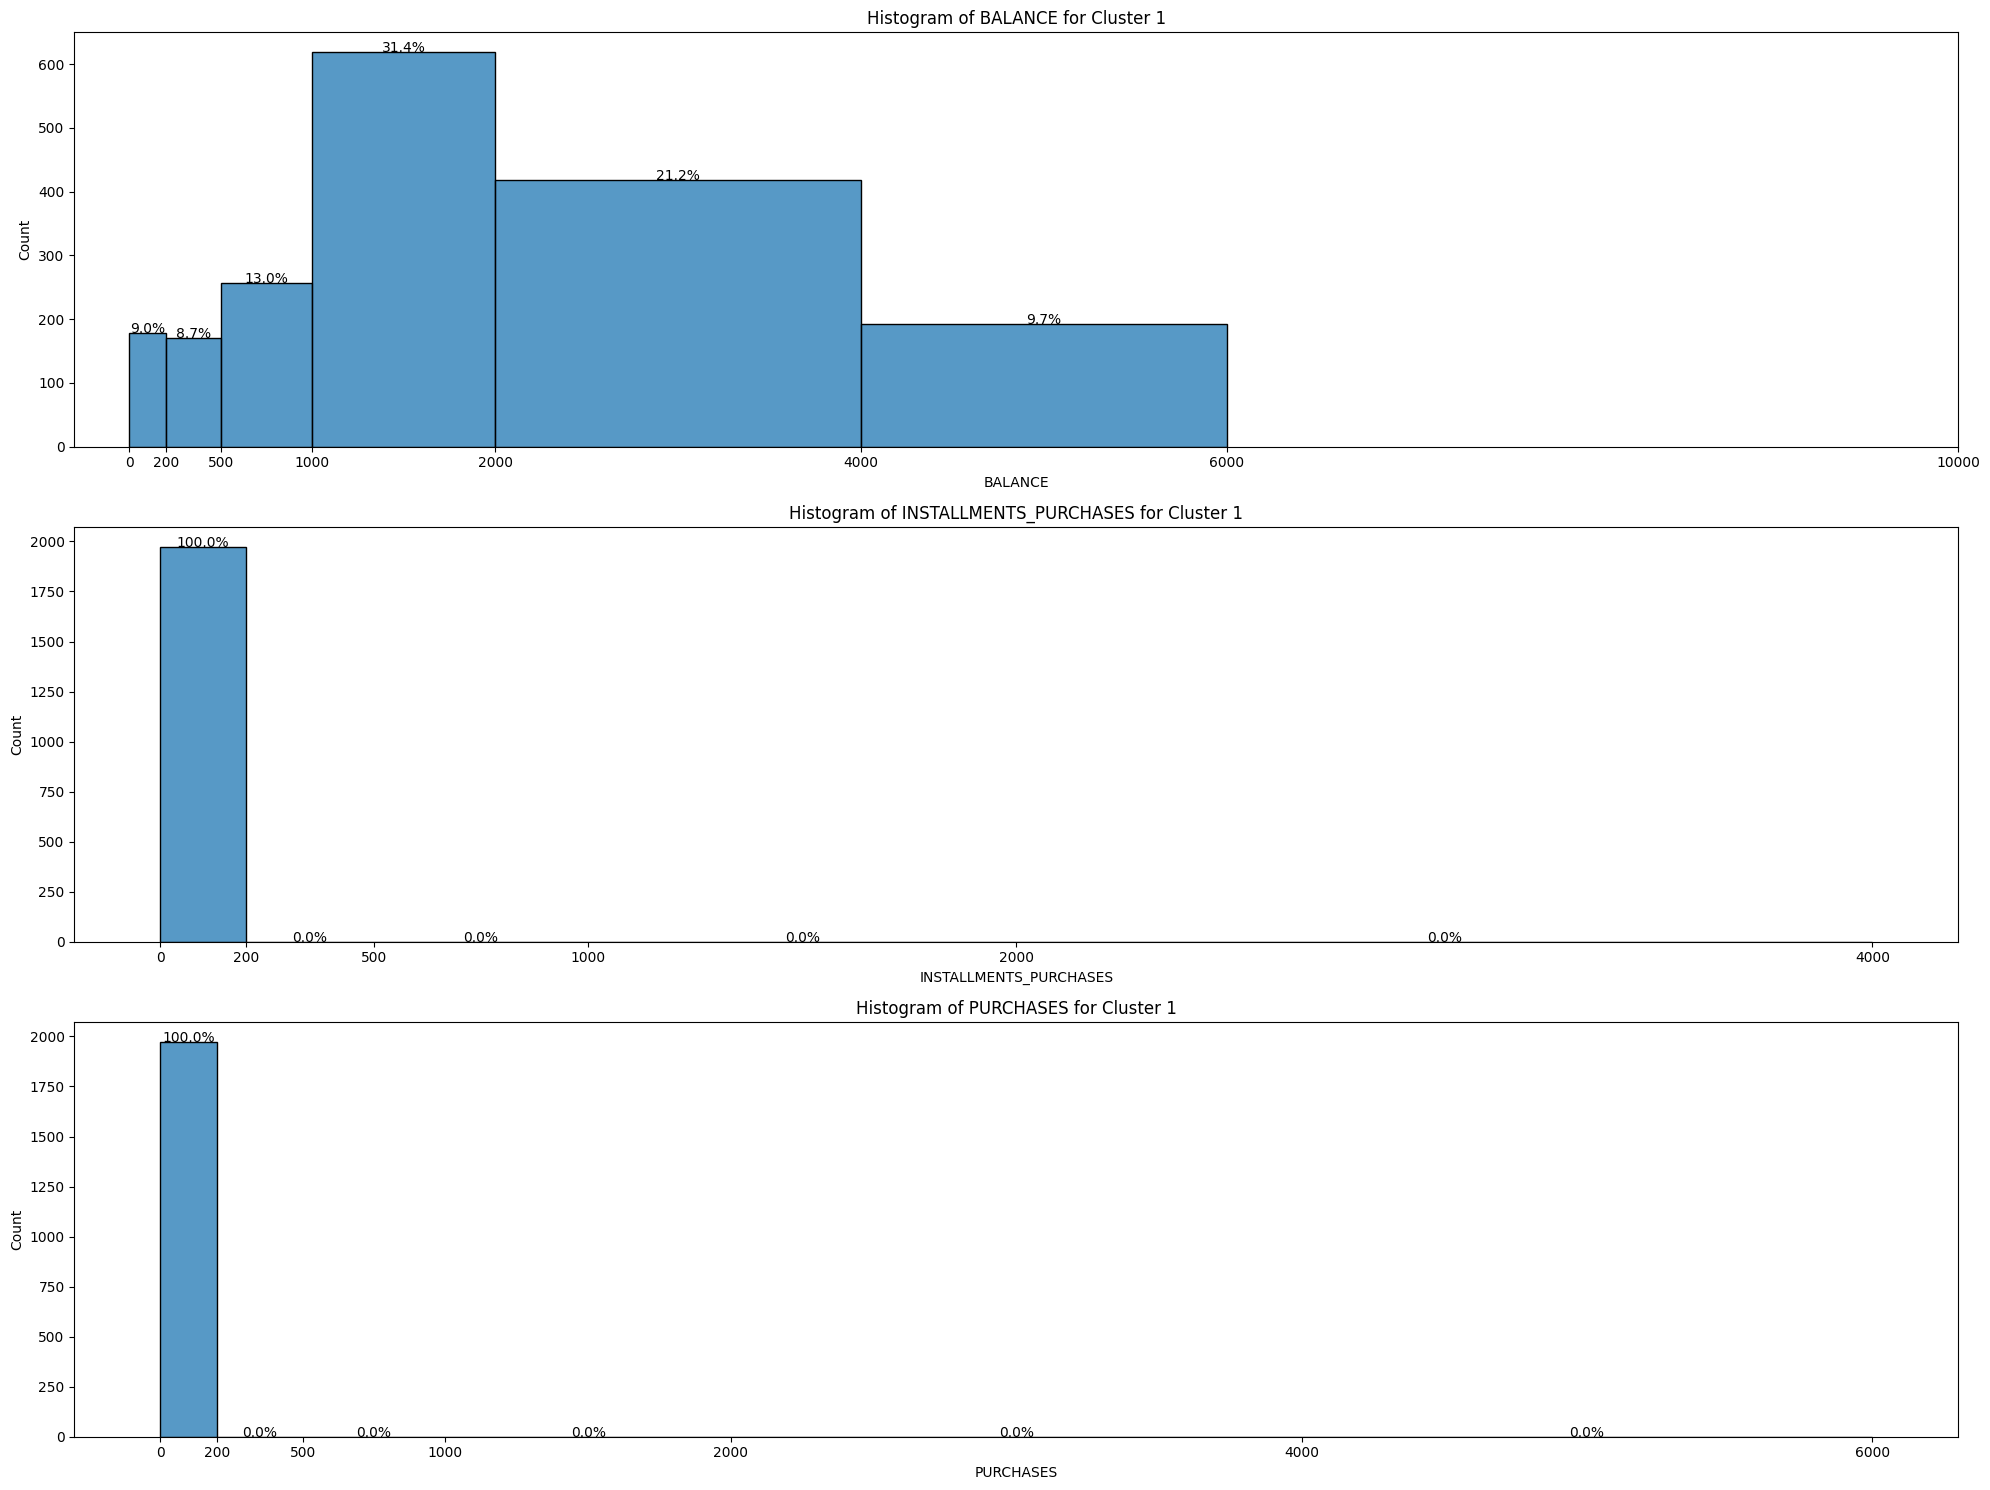

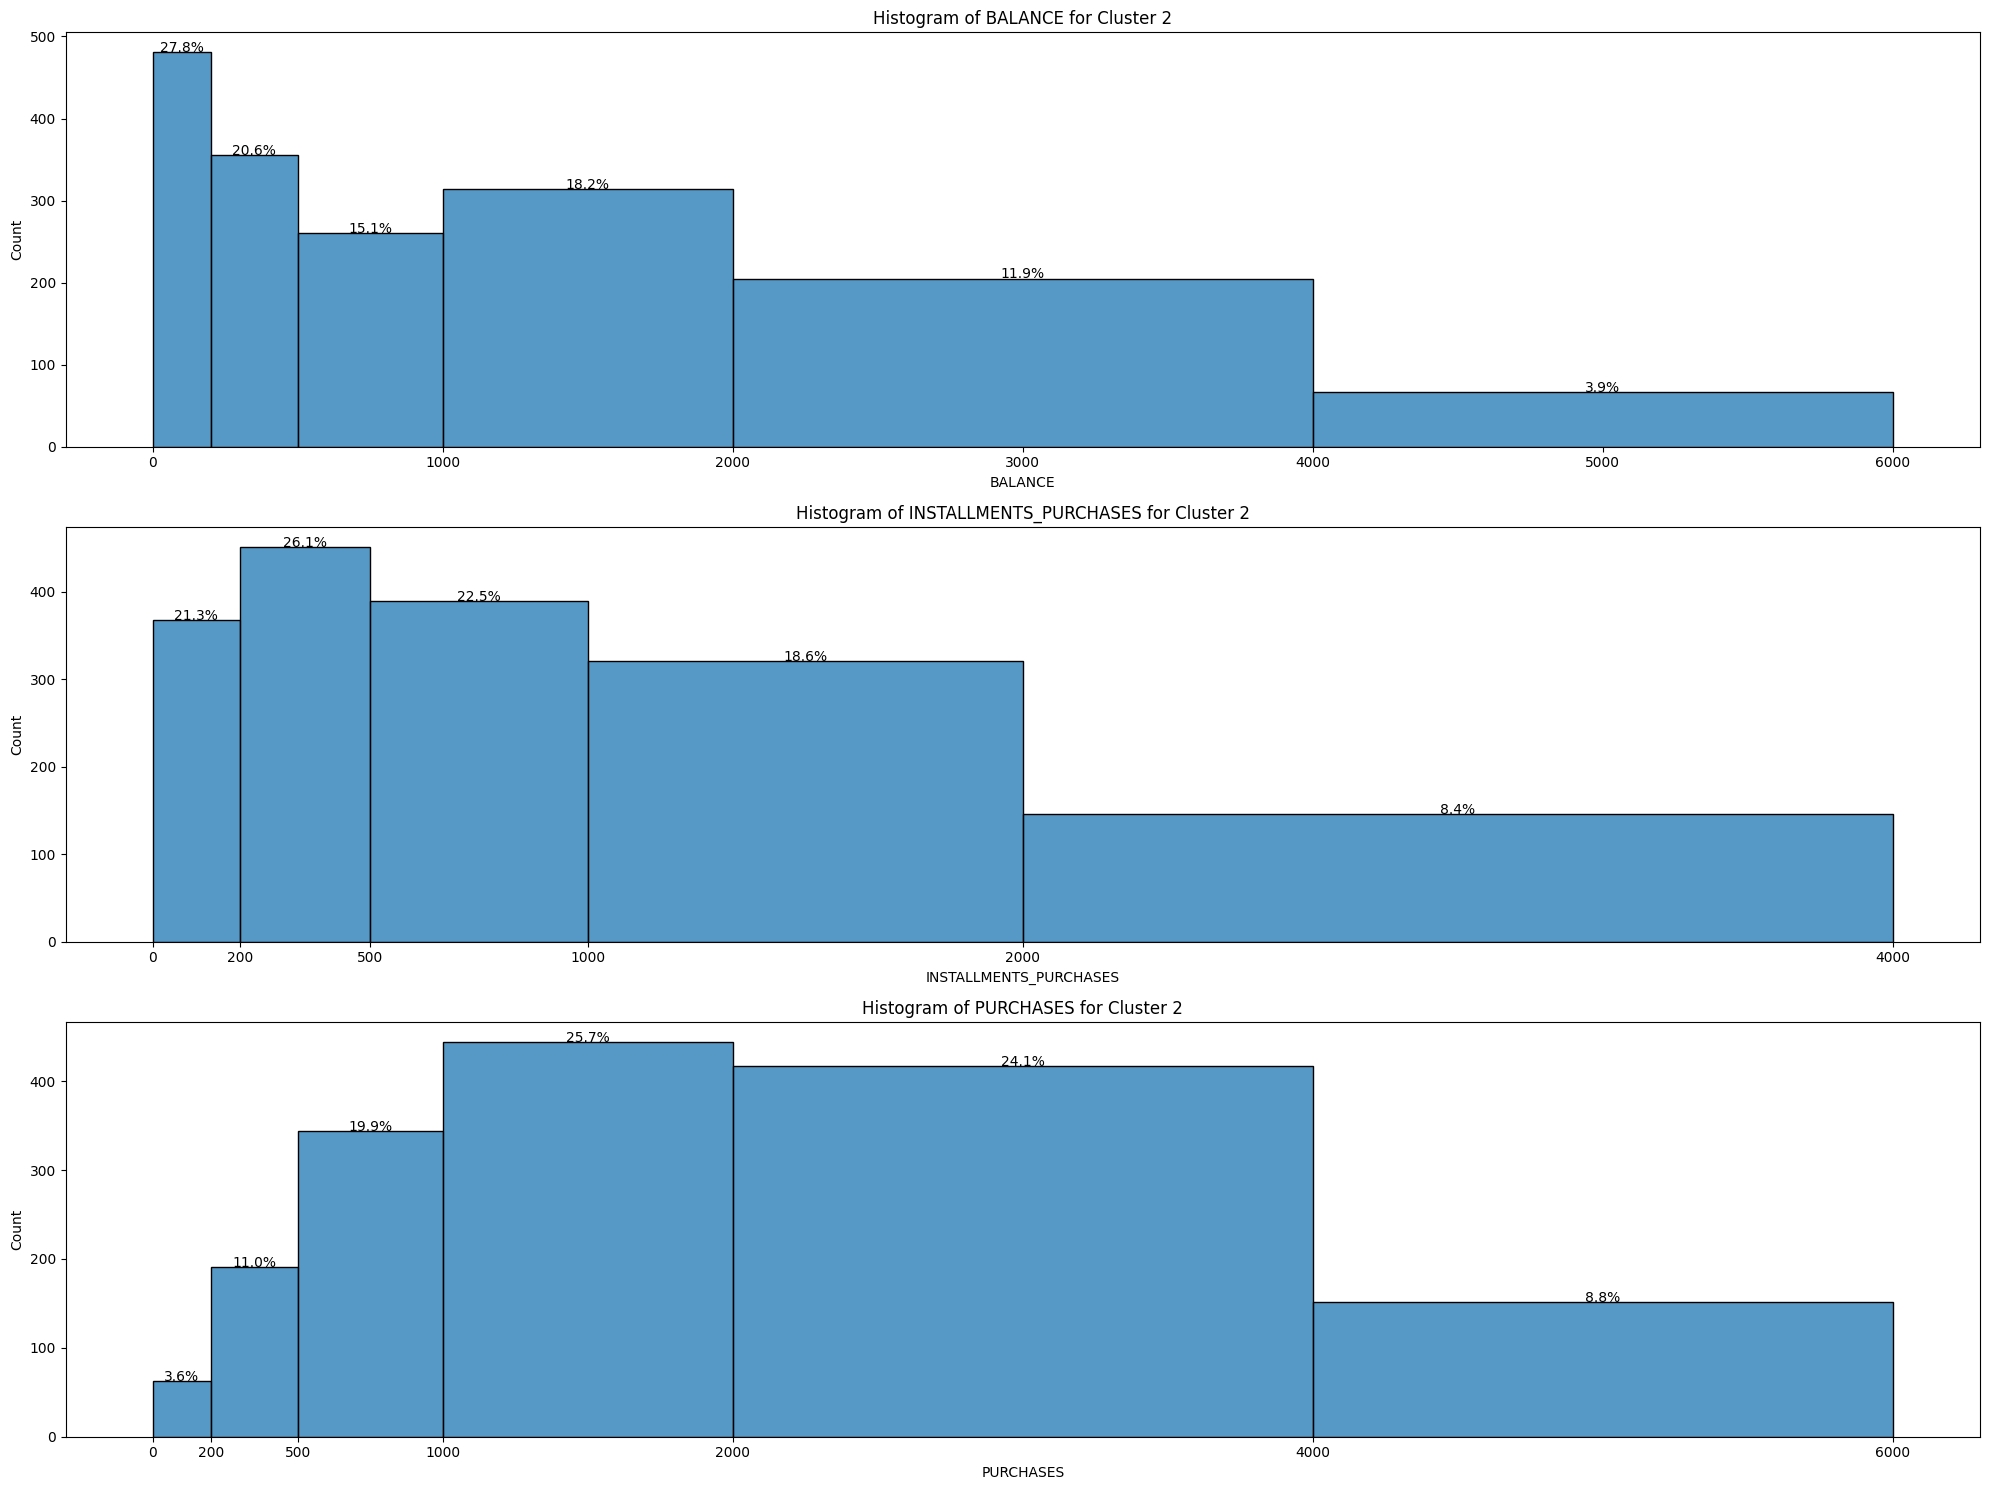

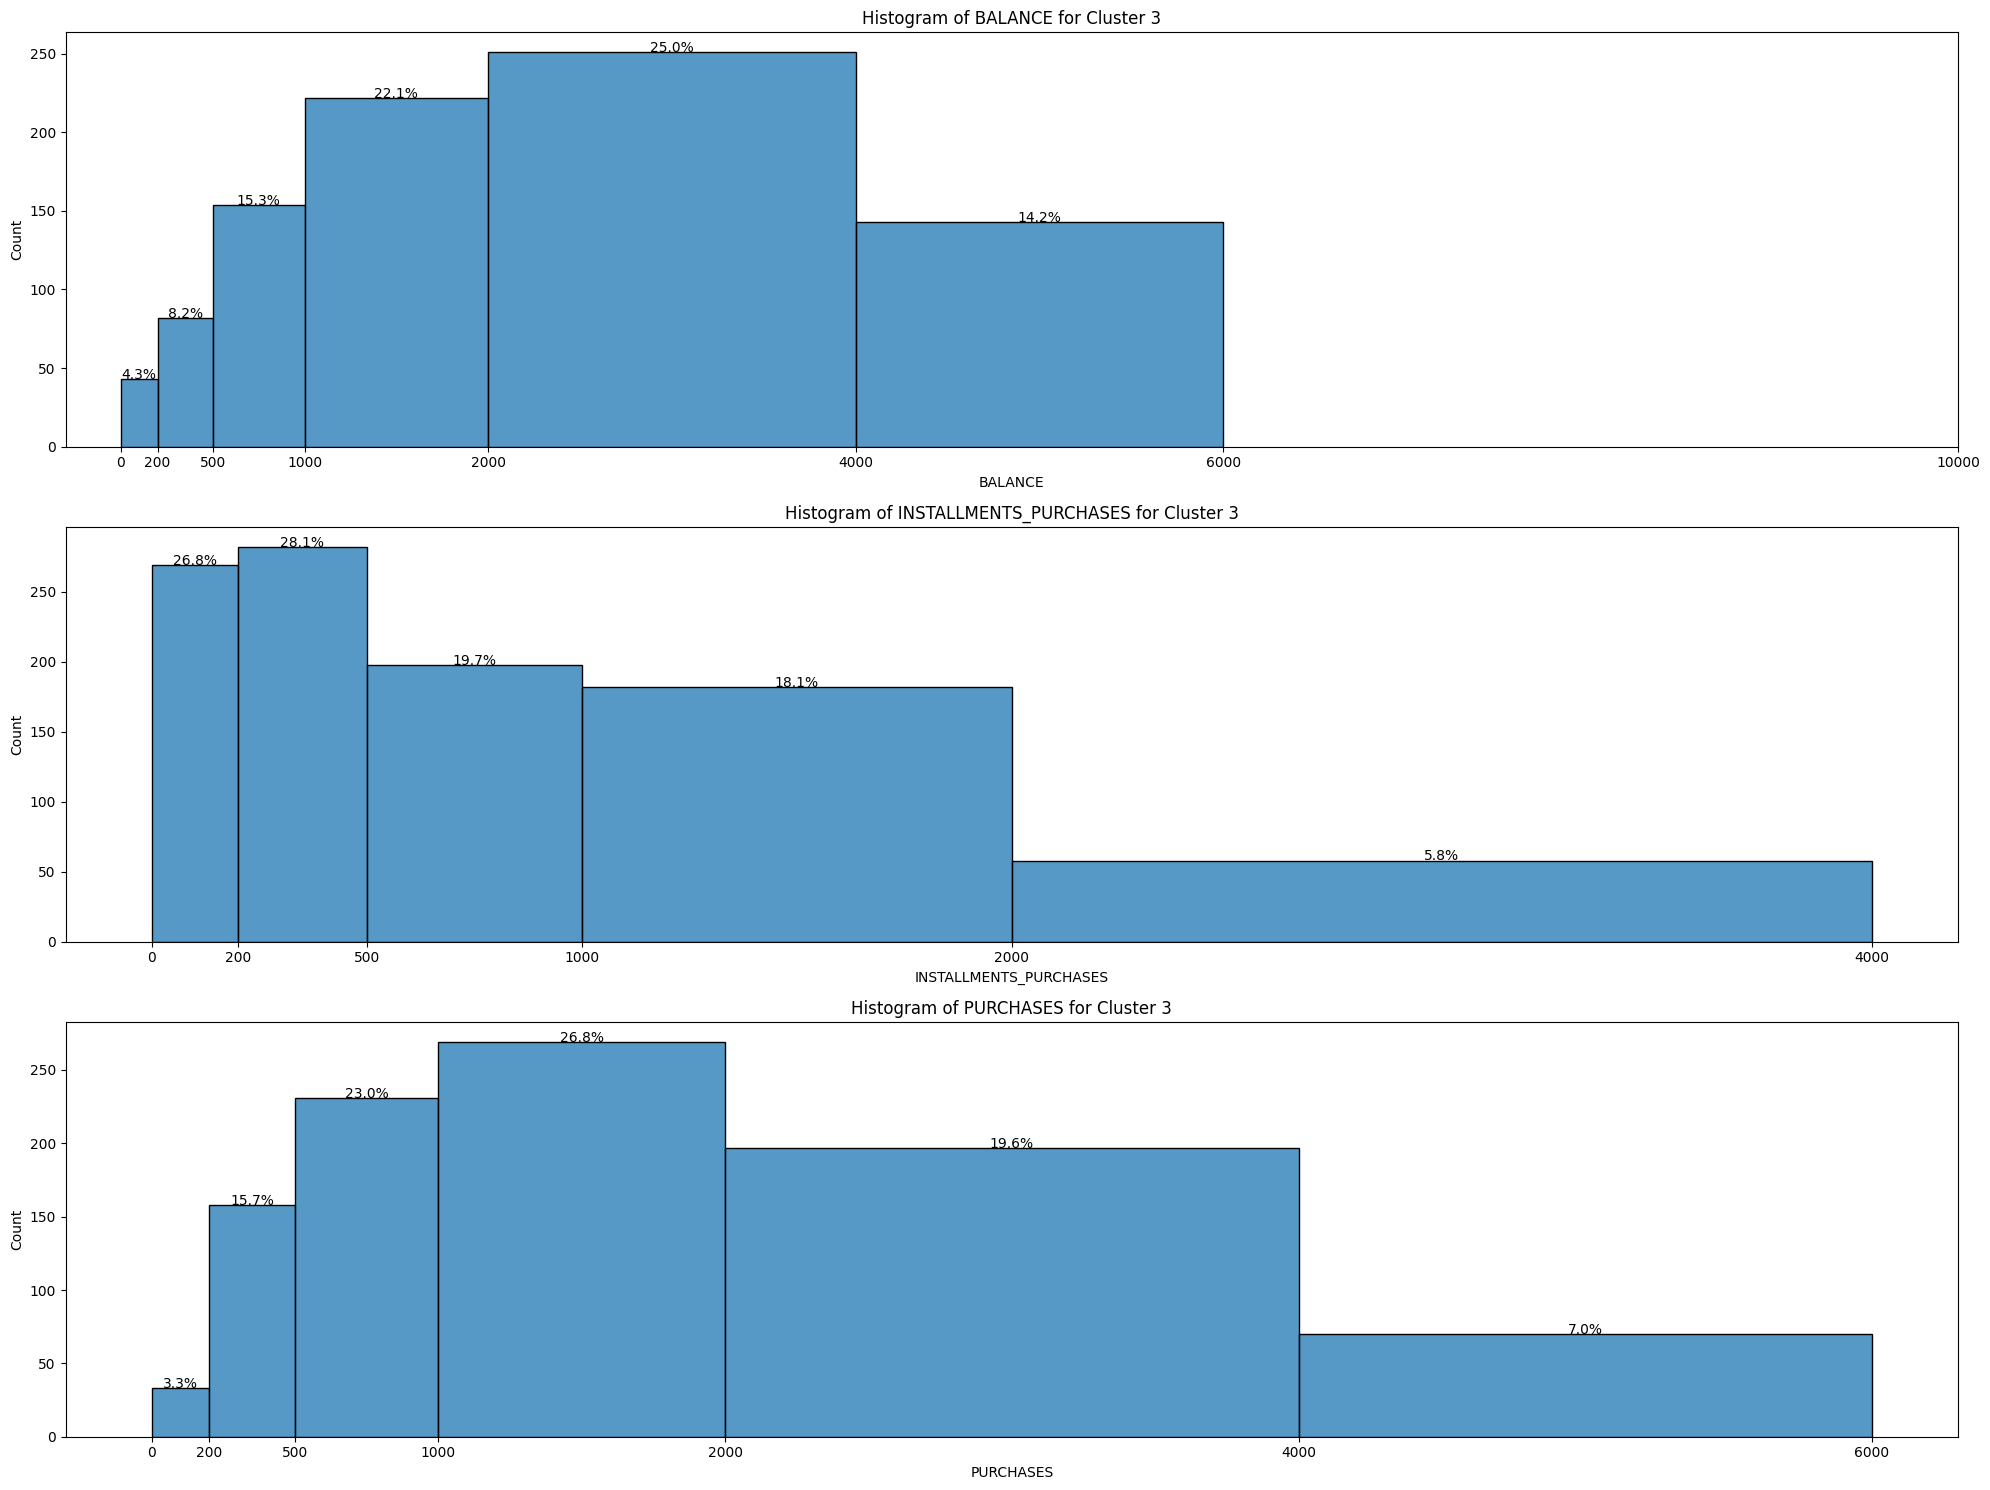

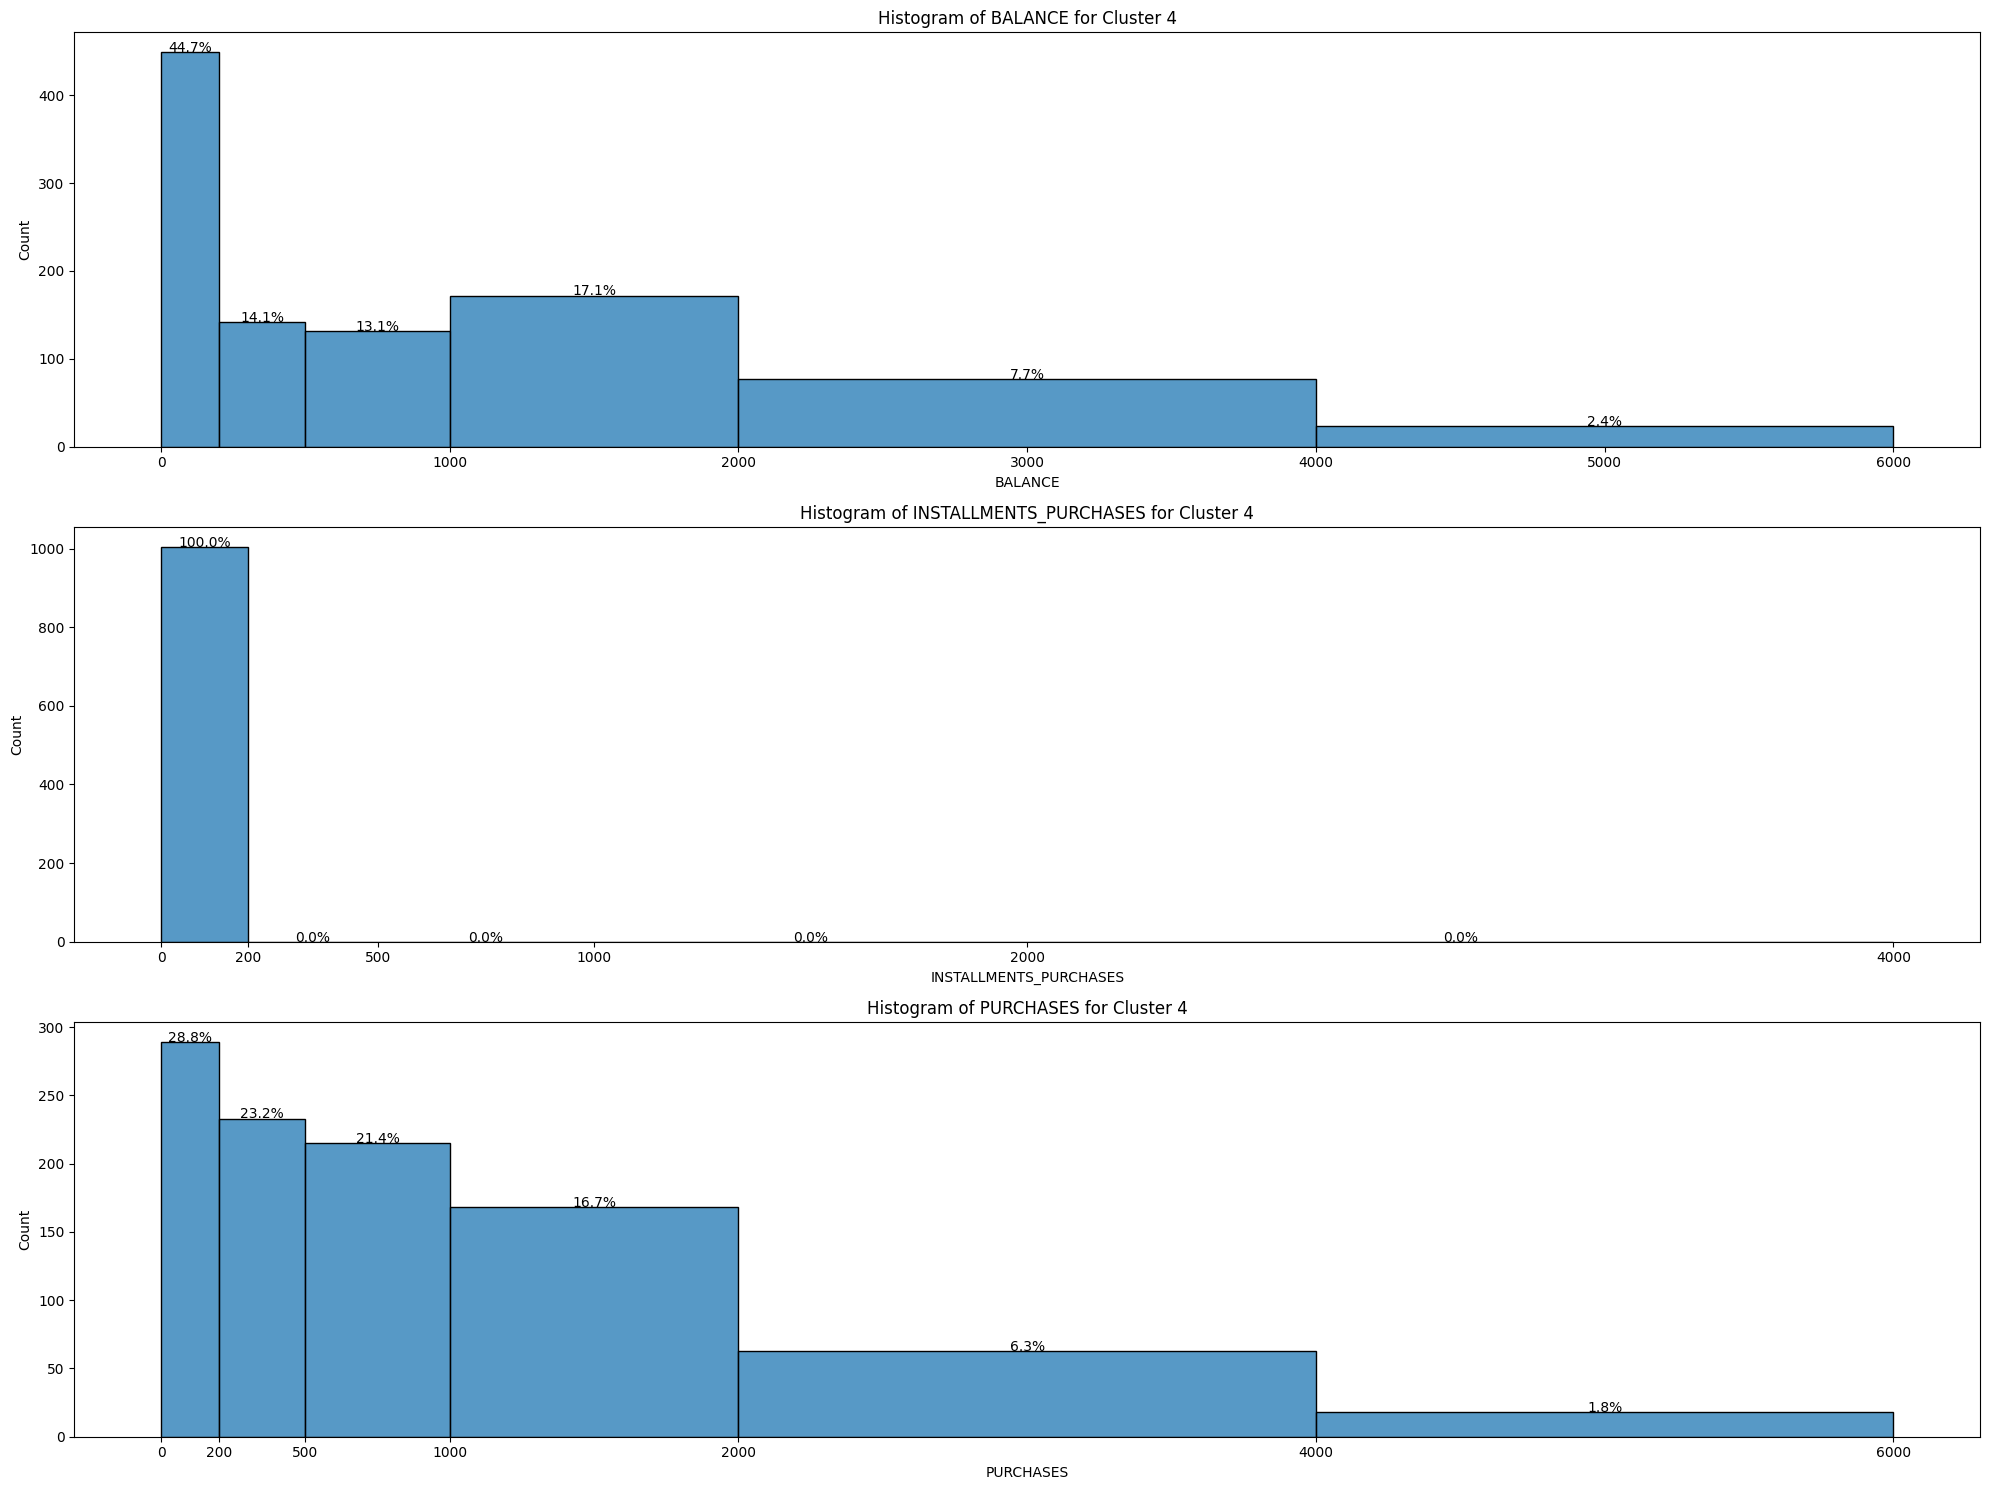

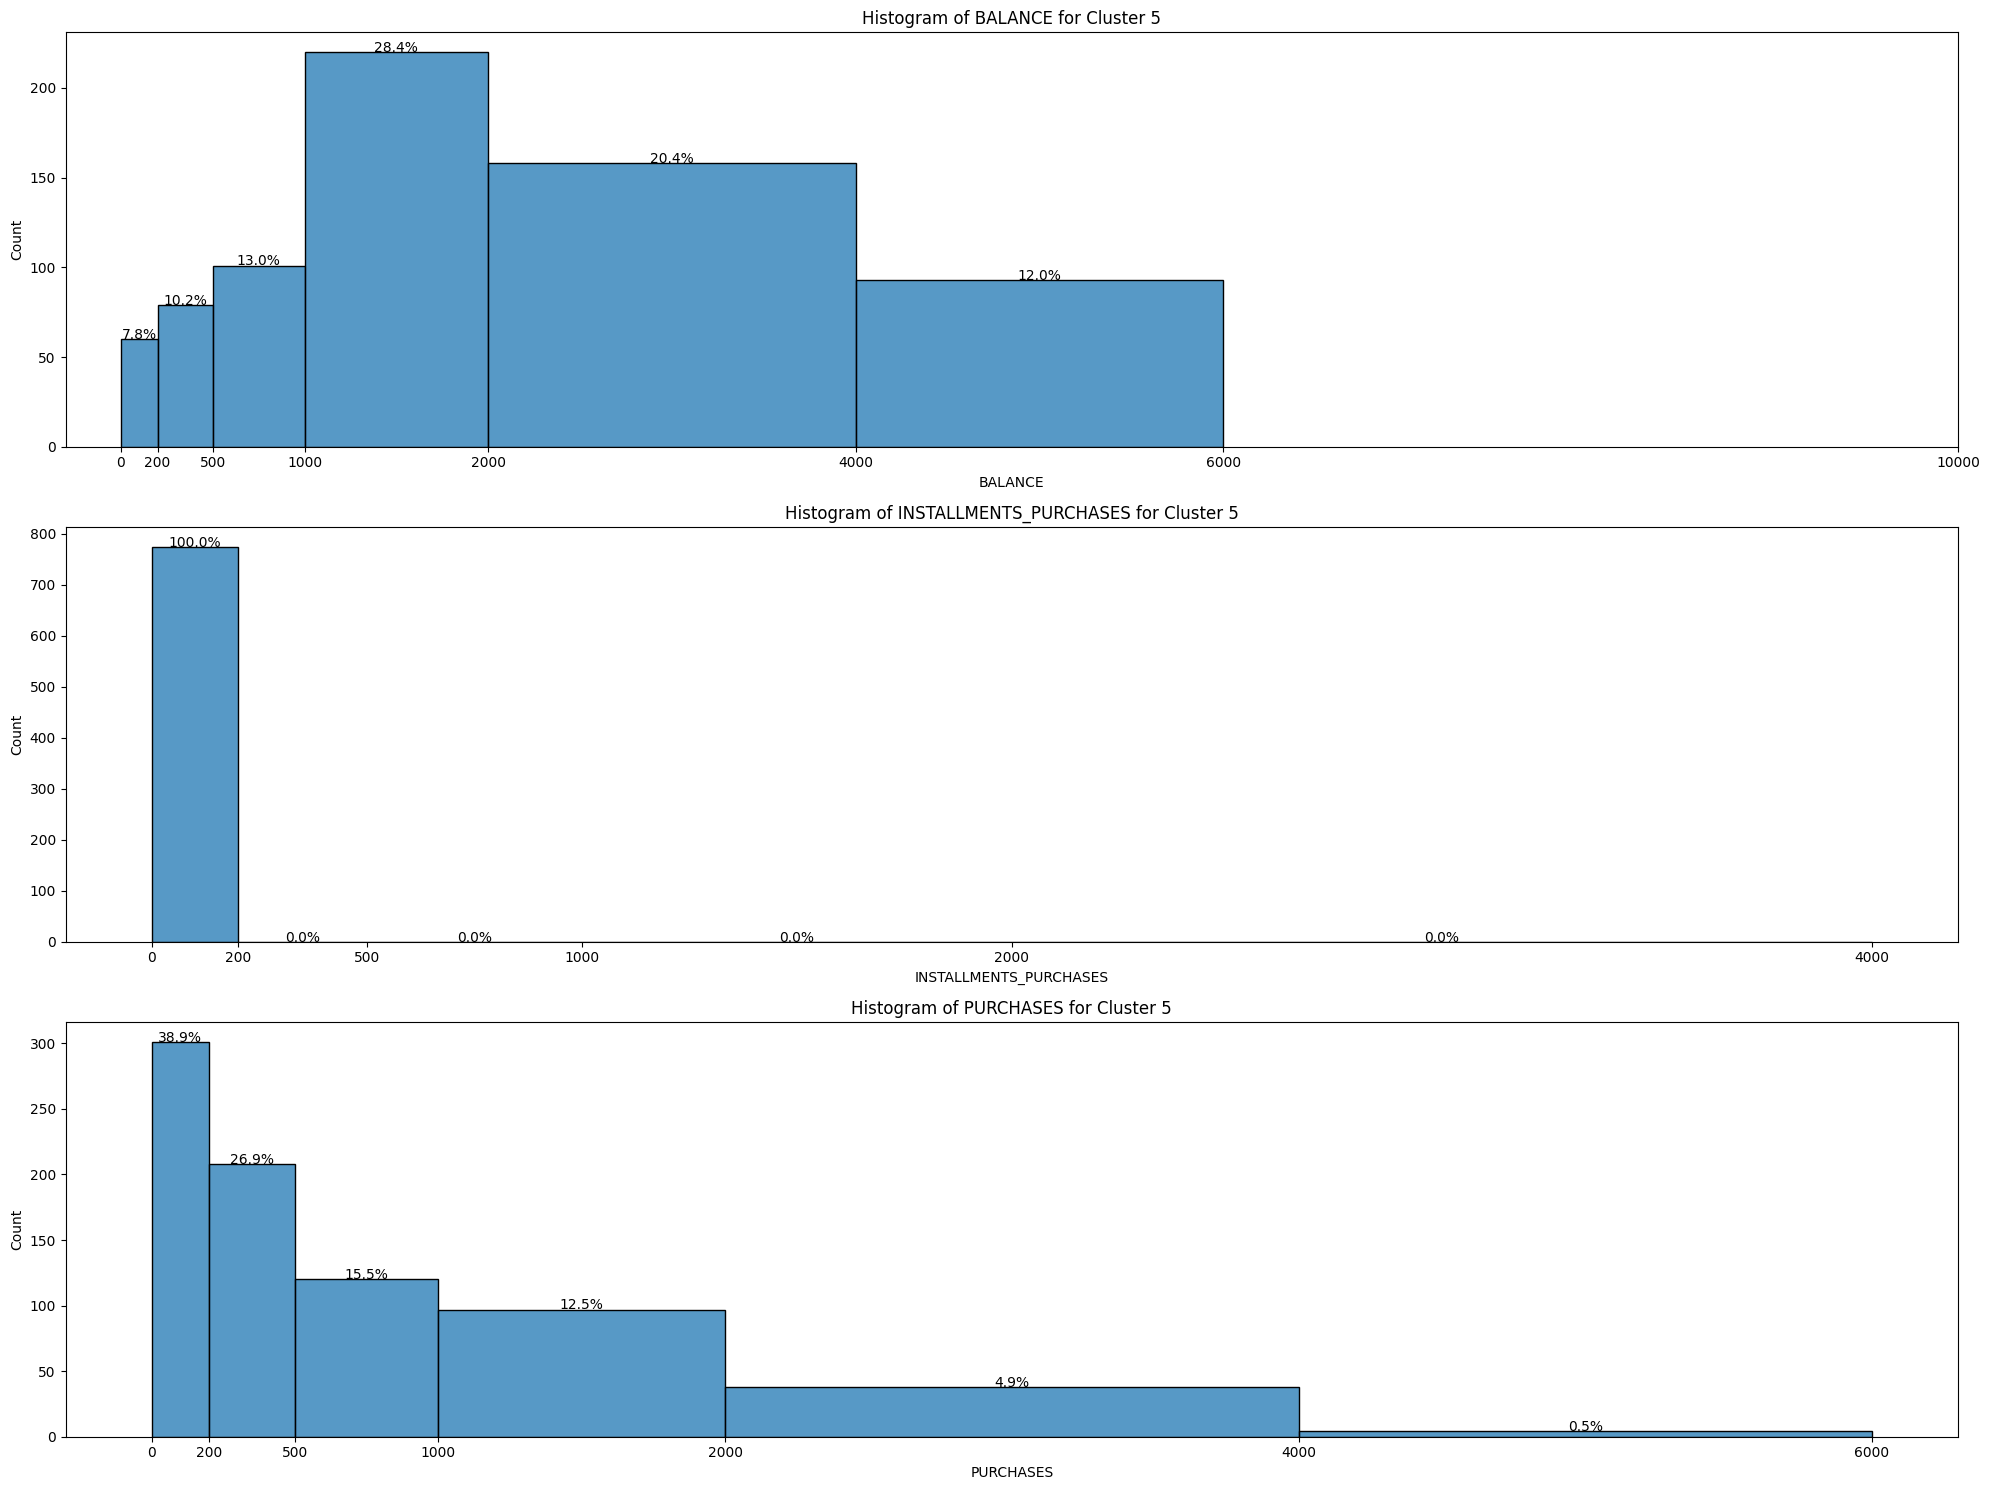

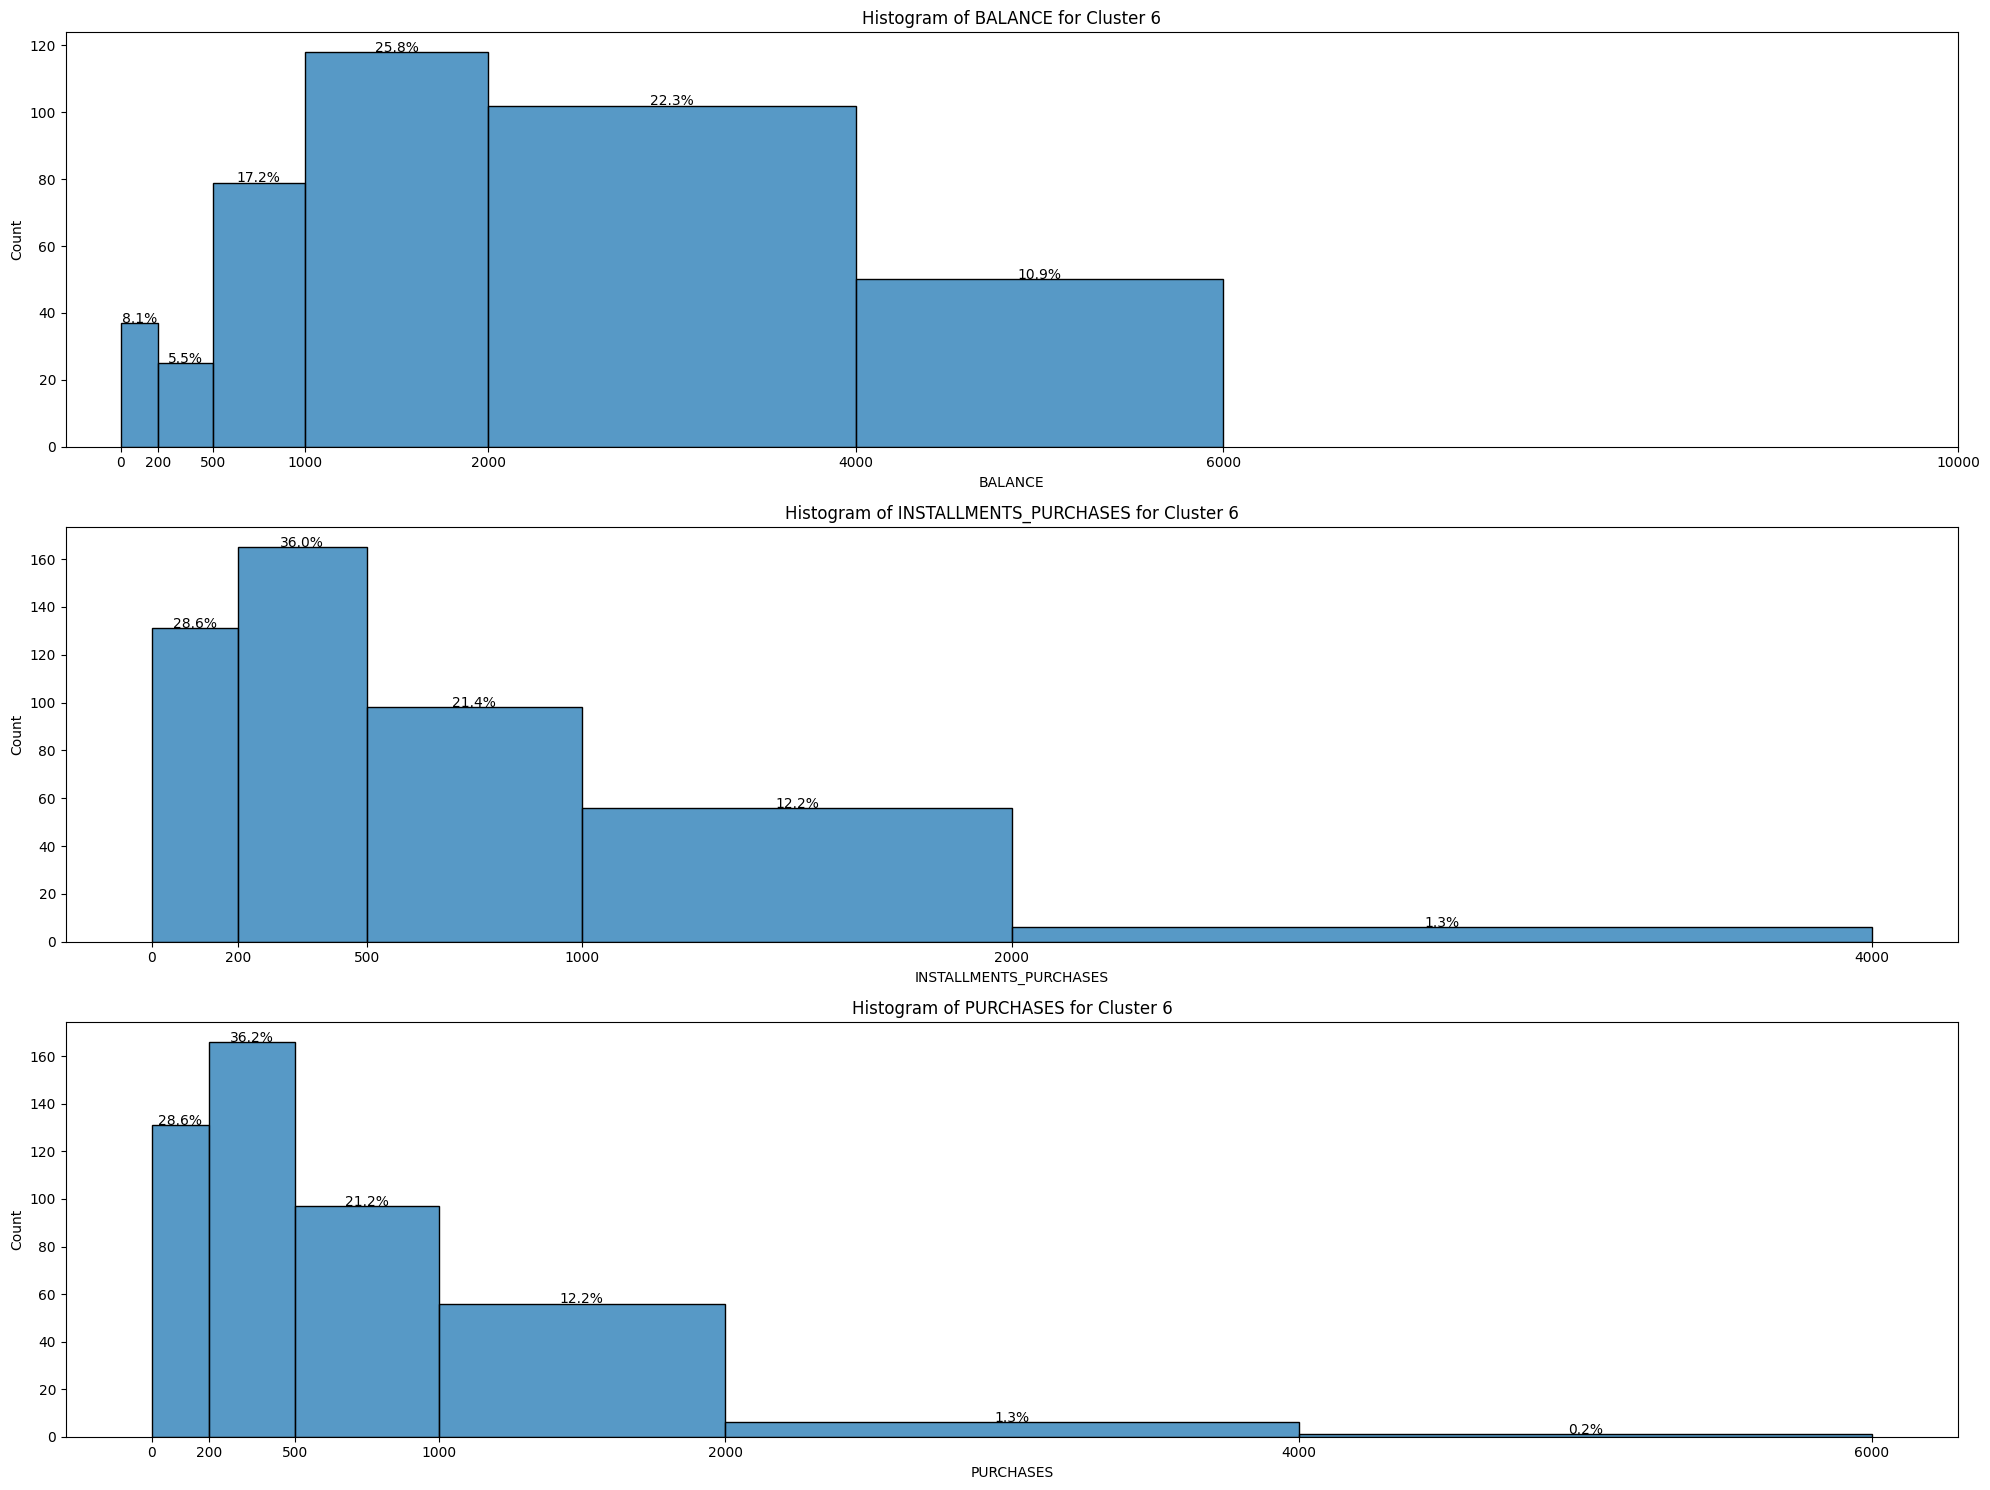

In [59]:

columns = ['BALANCE', 'INSTALLMENTS_PURCHASES', 'PURCHASES']
bins_balance = [0, 200, 500, 1000, 2000, 4000, 6000]
bins_INSTALLMENTS_PURCHASES = [0, 200, 500, 1000, 2000, 4000]
bins_PURCHASES = [0, 200, 500, 1000, 2000, 4000, 6000]

cluster_groups = df.groupby('cluster')

for cluster, group in cluster_groups:
    plt.figure(figsize=(20, 5 * len(columns)))
    for i, column in enumerate(columns, start=1):
        plt.subplot(len(columns), 1, i)
        if column == 'BALANCE':
            bins = bins_balance
        elif column == 'INSTALLMENTS_PURCHASES':
            bins = bins_INSTALLMENTS_PURCHASES
        else:
            bins = bins_PURCHASES

        ax = sns.histplot(data=group, x=column, bins=bins, stat='count')
        ax.set_title(f'Histogram of {column} for Cluster {cluster}')
        ax.set_ylabel('Count')

        total_count = len(group)
        patches = ax.patches
        for patch in patches:
            percentage = '{:.1f}%'.format(100 * (patch.get_height() / total_count))
            x = patch.get_x() + patch.get_width() / 2
            y = patch.get_height() + 0.05
            ax.annotate(percentage, (x, y), ha='center')

        if column == 'BALANCE':
            total_above_6000 = sum(group[column] > 6000)
            percentage_above_6000 = (total_above_6000 / total_count) * 100
            if percentage_above_6000 > 5:
                ax.set_xticks(bins + [10000])
        else:
            ax.set_xticks(bins)

    plt.tight_layout()
    plt.show()


## 6. <a name="6">improvement ideas</a>
(<a href="#0">Go to top</a>)

- Try to use PCA to reduce the number of features and compare how this will affect the clustring process
- Try to run your code again but with different tranformation technique
- Implement gap statistics method and use it as evaluation metric and compare the result with what you did before https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/#gap-statistic-method 

PCA

pca not affect the clusters appeared by other algorithims so we don't use it 

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.999)
pca_data_without_scaling = pca.fit_transform(df)

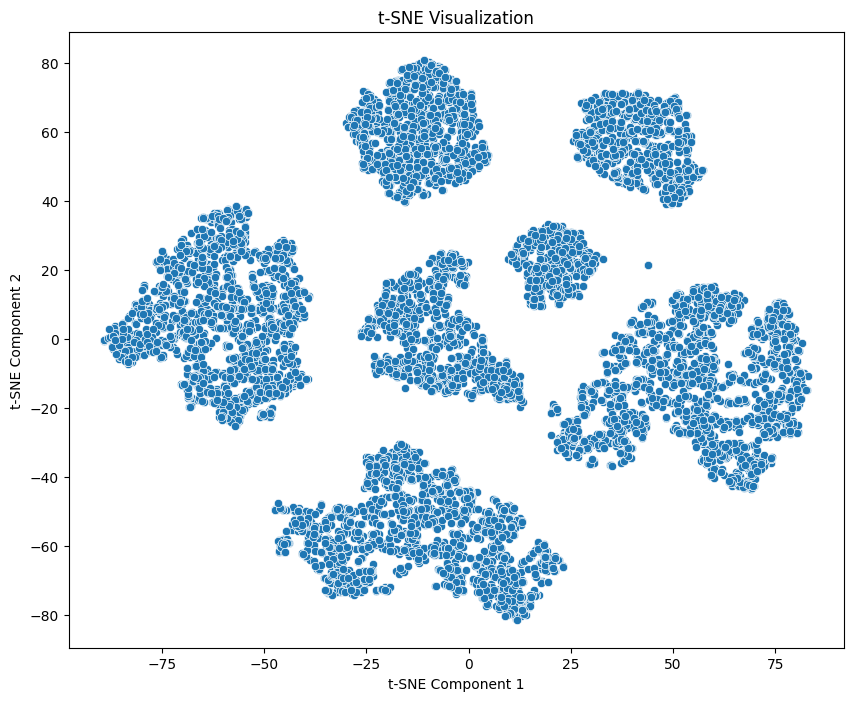

In [44]:
tsne = TSNE(n_components=2, random_state=42)
tsne_transformed = tsne.fit_transform(pca_data_without_scaling)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=tsne_transformed[:, 0], y=tsne_transformed[:, 1])
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()